<a href="https://colab.research.google.com/github/neuralresearch/CS39-6/blob/henry/TaGSim_Graph_Pooling_(LINUX).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys
import ast
print(sys.executable)
import os
import random
import networkx as nx
from matplotlib import pyplot as plt
import pylab
import re
import torch
import numpy as np
import pandas as pd
# 1.nr 2.nid 3.er 4.eid

/usr/bin/python3


In [ ]:
# Code to download file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#get the data from the drive https://drive.google.com/file/d/1YiX2r2glQ4r1hiy7BqAkSRyGvuPqBcne/view?usp=share_link
id = '1YiX2r2glQ4r1hiy7BqAkSRyGvuPqBcne'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('LINUX.zip')
!ls



LINUX.zip  sample_data


In [ ]:

!unzip /content/LINUX.zip

Archive:  /content/LINUX.zip
  inflating: generated/00000_NR_0_NID_7_ER_0_EID_1.gexf  
  inflating: generated/00001_NR_0_NID_4_ER_0_EID_4.gexf  
  inflating: generated/00002_NR_0_NID_1_ER_0_EID_7.gexf  
  inflating: generated/00003_NR_0_NID_1_ER_0_EID_7.gexf  
  inflating: generated/00004_NR_0_NID_1_ER_0_EID_7.gexf  
  inflating: generated/00005_NR_0_NID_4_ER_0_EID_4.gexf  
  inflating: generated/00006_NR_0_NID_4_ER_0_EID_4.gexf  
  inflating: generated/00007_NR_0_NID_6_ER_0_EID_2.gexf  
  inflating: generated/00008_NR_0_NID_3_ER_0_EID_5.gexf  
  inflating: generated/00009_NR_0_NID_2_ER_0_EID_6.gexf  
  inflating: generated/00011_NR_0_NID_3_ER_0_EID_5.gexf  
  inflating: generated/00012_NR_0_NID_5_ER_0_EID_3.gexf  
  inflating: generated/00013_NR_0_NID_5_ER_0_EID_3.gexf  
  inflating: generated/00014_NR_0_NID_1_ER_0_EID_7.gexf  
  inflating: generated/00015_NR_0_NID_1_ER_0_EID_7.gexf  
  inflating: generated/00016_NR_0_NID_5_ER_0_EID_3.gexf  
  inflating: generated/00017_NR_0_NID_2_ER_

In [ ]:
DATASET = "LINUX"
ORI_DIR = "/content/original"
GEN_DIR ="/content/generated"
TEST_DIR = "/content/test"
TEST_GEN_DIR = "/content/test"
DATASET_FOLDER = "/content"

In [ ]:
# test_csv = pd.DataFrame(test_data, columns=['G1', 'G2', 'gt_ged']).to_csv(DATASET_FOLDER + "/testing_pairs.csv",
#                                                                           index=False)
def load_pairs():
    train_pairs = []
    train_csv = pd.read_csv(DATASET_FOLDER+"/training_pairs.csv")
    for index, row in train_csv.iterrows():
        file1 = row['G1']
        file2 = row['G2']
        ged =ast.literal_eval(row['GED'])
        new_ged = [ged[1],ged[3]]
        gt_ged = row['gt_ged']
        graph1 = nx.read_gexf(path=ORI_DIR + '/' + file1)
        graph2 = nx.read_gexf(path=GEN_DIR + '/' + file2)
        train_pairs.append({"graph_pair": [graph1, graph2], "ged": new_ged, "gt_ged":gt_ged})


    test_pairs = []
    test_csv = pd.read_csv(DATASET_FOLDER+"/testing_pairs.csv")
    for index, row in test_csv.iterrows():
        file1 = row['G2']
        file2 = row['G1']
        gt_ged = row['gt_ged']
        graph1 = nx.read_gexf(path=TEST_GEN_DIR + '/' + file1)
        graph2 = nx.read_gexf(path=TEST_DIR + '/' + file2)
        test_pairs.append({"graph_pair": [graph1, graph2], "gt_ged": gt_ged})
    return train_pairs, test_pairs
train_pairs, test_pairs = load_pairs()
print(len(train_pairs))
print(train_pairs[0])
print(len(test_pairs))
print(test_pairs[0])

2001
{'graph_pair': [<networkx.classes.graph.Graph object at 0x7feb921ed550>, <networkx.classes.graph.Graph object at 0x7feb909edb10>], 'ged': [7, 1], 'gt_ged': 8}
70
{'graph_pair': [<networkx.classes.graph.Graph object at 0x7feb8785e790>, <networkx.classes.graph.Graph object at 0x7feb878710d0>], 'gt_ged': 11.0}


In [ ]:

epochs = 10
tensor_neurons = 16
bottle_neck_neurons = 16
batch_size = 128
dropout = 0.0
lr = 0.001
weight_decay = 0.0

Node_Types = ['1']
Edge_Types = ['1']
def fit(model,title):
  optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
  iteration = 0

  visual_loss_train = []
  visual_loss_test = []
  train_pair = []
  test_pair = []
  epo = []
  #model training
  for epoch in range(epochs):
    
      random.shuffle(train_pairs)
      batches = []
      for graph in range(0, len(train_pairs), batch_size):
          batches.append(train_pairs[graph:graph + batch_size])

      for batch in batches:
          model.train()
          optimizer.zero_grad()
          losses = 0
          for graph_pair in batch:
              data = model.transform_label_multiset(graph_pair)
              prediction = model(data)
              losses += torch.nn.functional.mse_loss(data["target"], prediction)

          losses.backward(retain_graph=True)
          optimizer.step()
          loss = losses.item()
          #print('Iteration', iteration, 'loss: ', loss / len(batch))
          iteration += 1

      visual_loss_train.append(loss / len(batch))


      # testing
      model.eval()
      test_scores=[]
      for n in test_pairs:
          graph1 = n['graph_pair'][0]  #updated_test
          graph2 = n['graph_pair'][1]  #updated_test
          ged = int(n['gt_ged'])
          tem_data = {"graph_pair": [graph1, graph2], "ged": ged}
          data = model.transform_label_multiset(tem_data, type_specified=False)
          prediction = model(data)
          prediction = torch.exp(torch.sum(torch.log(prediction))).view(1, -1)
          current_error = torch.nn.functional.mse_loss(prediction, data["gt_ged"])
          test_scores.append(current_error.data.item())
      visual_loss_test.append(sum(test_scores) / len(test_scores))
      epo.append(epoch + 1)


  #visualization of traning and testing loss
  plt.plot(epo, visual_loss_train, 'g', label='Training Loss')
  plt.plot(epo, visual_loss_test, 'b', label='Validation Error Rate')
  plt.title(title)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

  print("\n-------Model testing---------.\n")

  model.eval()
  test_scores = []
  for n in test_pairs:
      graph1 = n['graph_pair'][0]  #updated_test
      graph2 = n['graph_pair'][1]  #updated_test
      ged = int(n['gt_ged'])
      tem_data = {"graph_pair": [graph1, graph2], "ged": ged}
      data = model.transform_label_multiset(tem_data, type_specified=False)
      prediction = model(data)
      prediction = torch.exp(torch.sum(torch.log(prediction))).view(1, -1)
      prediction = torch.sum(prediction).view(1, -1)
      current_error = torch.nn.functional.mse_loss(prediction, data["gt_ged"])
      test_scores.append(current_error.data.item())

  model_error = sum(test_scores) / len(test_scores)
  print("\nModel test error: " + str(model_error))
  model.testResult=visual_loss_test

#MAX

In [ ]:


class TensorNetworkModule(torch.nn.Module):
    def __init__(self, tensor_neurons, input_dim):
        super(TensorNetworkModule, self).__init__()
        self.input_dim = input_dim
        self.tensor_neurons = tensor_neurons
        self.setup_weights()
        self.init_parameters()

    def setup_weights(self):
        self.weight_matrix = torch.nn.Parameter(torch.Tensor(self.input_dim, self.input_dim, self.tensor_neurons))
        self.weight_matrix_block = torch.nn.Parameter(torch.Tensor(self.tensor_neurons, 2 * self.input_dim))
        self.bias = torch.nn.Parameter(torch.Tensor(self.tensor_neurons, 1))

    def init_parameters(self):
        torch.nn.init.xavier_uniform_(self.weight_matrix)
        torch.nn.init.xavier_uniform_(self.weight_matrix_block)
        torch.nn.init.xavier_uniform_(self.bias)

    def forward(self, embedding_1, embedding_2):
        scoring = torch.mm(torch.t(embedding_1), self.weight_matrix.view(self.input_dim, -1))
        scoring = scoring.view(self.input_dim, self.tensor_neurons)
        scoring = torch.mm(torch.t(scoring), embedding_2)
        combined_representation = torch.cat((embedding_1, embedding_2))
        block_scoring = torch.mm(self.weight_matrix_block, combined_representation)
        scores = torch.nn.functional.relu(scoring + block_scoring + self.bias)
        return scores


def graph_aggregation_layer(input, adj):
    result = torch.mm(adj, input)
    return result


class TaGSim_max(torch.nn.Module):
    def __init__(self, number_of_node_labels, number_of_edge_labels, tensor_neurons, bottle_neck_neurons):
        super(TaGSim_max, self).__init__()
        # self.number_of_node_labels = len(number_of_node_labels)
        # self.number_of_edge_labels = len(number_of_edge_labels)
        self.tensor_neurons = tensor_neurons
        self.bottle_neck_neurons = bottle_neck_neurons
        self.testResult=[]
        self.setup_layers()



    def setup_layers(self):
        self.feature_count = self.tensor_neurons

        # self.tensor_network_nc = TensorNetworkModule(self.tensor_neurons, 2 * self.number_of_node_labels)
        self.tensor_network_in = TensorNetworkModule(self.tensor_neurons, 7)
        # self.tensor_network_ie = TensorNetworkModule(self.tensor_neurons, 2 * self.number_of_node_labels)
        self.tensor_network_ec = TensorNetworkModule(self.tensor_neurons, 23)

        # self.fully_connected_first_nc = torch.nn.Linear(self.feature_count, self.bottle_neck_neurons)
        # self.fully_connected_second_nc = torch.nn.Linear(self.bottle_neck_neurons, 8)
        # self.fully_connected_third_nc = torch.nn.Linear(8, 4)
        # self.scoring_layer_nc = torch.nn.Linear(4, 1)

        self.fully_connected_first_in = torch.nn.Linear(self.feature_count, self.bottle_neck_neurons)
        self.fully_connected_second_in = torch.nn.Linear(self.bottle_neck_neurons, 8)
        self.fully_connected_third_in = torch.nn.Linear(8, 4)
        self.scoring_layer_in = torch.nn.Linear(4, 1)

        # self.fully_connected_first_ie = torch.nn.Linear(self.feature_count, self.bottle_neck_neurons)
        # self.fully_connected_second_ie = torch.nn.Linear(self.bottle_neck_neurons, 8)
        # self.fully_connected_third_ie = torch.nn.Linear(8, 4)
        # self.scoring_layer_ie = torch.nn.Linear(4, 1)

        self.fully_connected_first_ec = torch.nn.Linear(self.feature_count, self.bottle_neck_neurons)
        self.fully_connected_second_ec = torch.nn.Linear(self.bottle_neck_neurons, 8)
        self.fully_connected_third_ec = torch.nn.Linear(8, 4)
        self.scoring_layer_ec = torch.nn.Linear(4, 1)

    def gal_pass(self, edge_index, features):
        hidden1 = graph_aggregation_layer(features, edge_index)
        hidden2 = graph_aggregation_layer(hidden1, edge_index)
        return hidden1, hidden2

    def transform_label_multiset(self, graph_pair, type_specified=True):
        graph1 = graph_pair['graph_pair'][0]
        graph2 = graph_pair['graph_pair'][1]
        ged = graph_pair['ged']

        label_multiset = dict()
        node_features_1, node_features_2= [], []

        for i in graph1.nodes():
            node_features_1.append([1.0])
        for i in graph2.nodes():
            node_features_2.append([1.0])

        node_features_1, node_features_2 = torch.FloatTensor(np.array(node_features_1)), torch.FloatTensor(
            np.array(node_features_2))

        #label_multiset["edge_index_1"], label_multiset["edge_index_2"] = nx.adjacency_matrix(graph1), nx.adjacency_matrix(graph2)
        label_multiset["features_1"], label_multiset["features_2"] = node_features_1, node_features_2

        # label_multiset["node_index_1"], label_multiset["node_index_2"] = nx.adjacency_matrix(
        #     graph1), nx.adjacency_matrix(graph2)
        # label_multiset["node_features_1"], label_multiset["node_features_2"] = node_features_1, node_features_2
        # label_multiset["edge_features_1"], label_multiset["edge_features_2"] = edge_features_1, edge_features_2
        # label_multiset["edge_adj_1"], label_multiset["edge_adj_2"] = edge_adj_1, edge_adj_2

        edges1 = list(graph1.edges())
        edges2 = list(graph2.edges())

        node_features_1, node_features_2, edge_features_1, edge_features_2, edge_adj_1, edge_adj_2 = [], [], [], [], [], []

        for i in graph1.nodes():
            node_features_1.append([1.0  ])
        for i in graph2.nodes():
            node_features_2.append([1.0  ])
            

        for i in edges1:
            edge_features_1.append([1.0 ])
            adj_row = []
            for d in edges1:
                if (i == d):
                    adj_row.append(0.0)
                    continue
                if ((i[0] in d) | (i[1] in d)):
                    adj_row.append(1.0)
                else:
                    adj_row.append(0.0)
            edge_adj_1.append(adj_row)
        for i in edges2:
            edge_features_2.append([1.0  ])
            adj_row = []
            for d in edges2:
                if (i == d):
                    adj_row.append(0.0)
                    continue
                if ((i[0] in d) | (i[1] in d)):
                    adj_row.append(1.0)
                else:
                    adj_row.append(0.0)
            edge_adj_2.append(adj_row)
        edge_features_1, edge_features_2 = torch.FloatTensor(np.array(edge_features_1)), torch.FloatTensor(
            np.array(edge_features_2))
        edge_adj_1, edge_adj_2 = torch.FloatTensor(np.array(edge_adj_1)), torch.FloatTensor(np.array(edge_adj_2))


        label_multiset["edge_features_1"], label_multiset["edge_features_2"] = edge_features_1, edge_features_2
        label_multiset["edge_adj_1"], label_multiset["edge_adj_2"] = edge_adj_1, edge_adj_2

        node_features_1,node_features_2=        nx.adjacency_matrix(graph1).todense(), nx.adjacency_matrix(graph2).todense()
        #label_multiset["edge_index_1"], label_multiset["edge_index_2"] = nx.adjacency_matrix(graph1), nx.adjacency_matrix(graph2)
        label_multiset["node_adj_1"], label_multiset["node_adj_2"] =torch.FloatTensor(np.array(node_features_1)), torch.FloatTensor(
            np.array(node_features_2))
        
        #ged normalisation
        if (type_specified):  # for training
            avg_node_number = 0.5 * (graph1.number_of_nodes() + graph2.number_of_nodes())
            norm_ged = [n / avg_node_number for n in ged]
            norm_ged = np.array(norm_ged)
            label_multiset["target"] = torch.from_numpy(np.exp(-norm_ged)).view(1, -1).float()

            norm_gt_ged = (sum(ged)) / (0.5 * (graph1.number_of_nodes() + graph2.number_of_nodes()))
            label_multiset["gt_ged"] = torch.from_numpy(np.exp(-norm_gt_ged).reshape(1, 1)).view(1, -1).float()
        else:  # for testing
            norm_gt_ged = (ged) / (0.5 * (graph1.number_of_nodes() + graph2.number_of_nodes()))
            label_multiset["gt_ged"] = torch.from_numpy(np.exp(-norm_gt_ged).reshape(1, 1)).view(1, -1).float()

        return label_multiset
    def forward(self, label_multiset):
      adj_1 =  label_multiset["edge_adj_1"]
      adj_2 =  label_multiset["edge_adj_2"] 
      adj_1 =  label_multiset["node_adj_1"]
      adj_2 =  label_multiset["node_adj_2"] 
      features_1, features_2 = label_multiset["features_1"],label_multiset["features_2"]
      edge_adj_1, edge_adj_2 = label_multiset["edge_adj_1"], label_multiset["edge_adj_2"]
      
      edge_features_1, edge_features_2 = label_multiset["edge_features_1"], label_multiset["edge_features_2"]

              
      graph1_hidden1, graph1_hidden2 = self.gal_pass(adj_1, features_1)#
      graph2_hidden1, graph2_hidden2 = self.gal_pass(adj_2, features_2)#
    
      Graph1_hidden1, Graph1_hidden2, Graph2_hidden1, Graph2_hidden2 = [], [], [], []
      for i in range(graph1_hidden1.size()[0]):
        if(graph1_hidden1[i][0] >= 6):# 10 for imdb; 6 for linux # the valus here can be set by the users
            Graph1_hidden1.append([0.0]*5 + [1.0])
        else:
            Graph1_hidden1.append([1.0 if graph1_hidden1[i][0] == j else 0.0 for j in range(6)])

        if(graph1_hidden2[i][0] >= 15):# 50 for imdb; 15 for linux # the valus here can be set by the users
            Graph1_hidden2.append([0.0]*14 + [1.0])
        else:
            Graph1_hidden2.append([1.0 if graph1_hidden2[i][0] == j else 0.0 for j in range(15)])

      for i in range(graph2_hidden1.size()[0]):
          if(graph2_hidden1[i][0] >= 6):# 10 for imdb; 6 for linux # the valus here can be set by the users
              Graph2_hidden1.append([0.0]*5 + [1.0])
          else:
              Graph2_hidden1.append([1.0 if graph2_hidden1[i][0] == j else 0.0 for j in range(6)])

          if(graph2_hidden2[i][0] >= 15):# 50 for imdb; 15 for linux # the valus here can be set by the users
              Graph2_hidden2.append([0.0]*14 + [1.0])
          else:
              Graph2_hidden2.append([1.0 if graph2_hidden2[i][0] == j else 0.0 for j in range(15)])
      Graph1_hidden1, Graph1_hidden2 = torch.FloatTensor(np.array(Graph1_hidden1)), torch.FloatTensor(np.array(Graph1_hidden2))
      Graph2_hidden1, Graph2_hidden2 = torch.FloatTensor(np.array(Graph2_hidden1)), torch.FloatTensor(np.array(Graph2_hidden2))


      edge1_hidden1, edge1_hidden2 = self.gal_pass(edge_adj_1, edge_features_1)  #original edge node
      edge2_hidden1, edge2_hidden2 = self.gal_pass(edge_adj_2, edge_features_2)  #generated graph edge


      graph1_01concat = torch.cat([features_1, Graph1_hidden1], dim=1)
      graph2_01concat = torch.cat([features_2, Graph2_hidden1], dim=1)
      graph1_12concat = torch.cat([Graph1_hidden1, Graph1_hidden2], dim=1)
      graph2_12concat = torch.cat([Graph2_hidden1, Graph2_hidden2], dim=1)

      graph1_01pooled = torch.max(graph1_01concat, dim=0).values.unsqueeze(1)

      graph2_01pooled = torch.max(graph2_01concat, dim=0).values.unsqueeze(1)
      graph1_12pooled = torch.max(graph1_12concat,  dim=0).values
      graph2_12pooled = torch.max(graph2_12concat, dim=0).values



      scores_in = self.tensor_network_in(graph1_01pooled, graph2_01pooled)
      scores_in = torch.t(scores_in)

      scores_in = torch.nn.functional.relu(self.fully_connected_first_in(scores_in))
      scores_in = torch.nn.functional.relu(self.fully_connected_second_in(scores_in))
      scores_in = torch.nn.functional.relu(self.fully_connected_third_in(scores_in))
      score_in = torch.sigmoid(self.scoring_layer_in(scores_in))
        #edge level embedding Concatenation
      edge1_01concat = torch.cat([ edge_features_1, edge1_hidden1], dim=1)
      edge2_01concat = torch.cat([ edge_features_2, edge2_hidden1], dim=1)
      #graph pooling: edge Sum
      edge1_01pooled = torch.max(edge1_01concat, dim=0).values
      edge2_01pooled = torch.max(edge2_01concat, dim=0).values

      graph1_ec_input=torch.cat([ graph1_12pooled, edge1_01pooled]).unsqueeze(1)
      graph2_ec_input=torch.cat([ graph2_12pooled, edge2_01pooled]).unsqueeze(1)
      scores_ec = self.tensor_network_ec(graph1_ec_input, graph2_ec_input)
      scores_ec = torch.t(scores_ec)

      scores_ec = torch.nn.functional.relu(self.fully_connected_first_ec(scores_ec))
      scores_ec = torch.nn.functional.relu(self.fully_connected_second_ec(scores_ec))
      scores_ec = torch.nn.functional.relu(self.fully_connected_third_ec(scores_ec))
      score_ec = torch.sigmoid(self.scoring_layer_ec(scores_ec))
                     #edge insert
      return torch.cat([score_in, score_ec], dim=1)



-------Model training---------.

Iteration 0 loss:  0.1134093701839447
Iteration 1 loss:  0.11028896272182465
Iteration 2 loss:  0.11890818178653717
Iteration 3 loss:  0.11349998414516449
Iteration 4 loss:  0.1235722228884697
Iteration 5 loss:  0.11336361616849899
Iteration 6 loss:  0.10773670673370361
Iteration 7 loss:  0.11496525257825851
Iteration 8 loss:  0.09830509126186371
Iteration 9 loss:  0.10252616554498672
Iteration 10 loss:  0.10174008458852768
Iteration 11 loss:  0.09287436306476593
Iteration 12 loss:  0.099021777510643
Iteration 13 loss:  0.10079608857631683
Iteration 14 loss:  0.09234999120235443
Iteration 15 loss:  0.10282318680374711
Iteration 16 loss:  0.10458853095769882
Iteration 17 loss:  0.09911065548658371
Iteration 18 loss:  0.09246283769607544
Iteration 19 loss:  0.09895353764295578
Iteration 20 loss:  0.08718311786651611
Iteration 21 loss:  0.09646071493625641
Iteration 22 loss:  0.09660536795854568
Iteration 23 loss:  0.09654116630554199
Iteration 24 loss:  

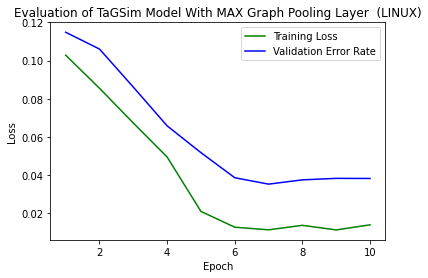


-------Model testing---------.


Model test error: 0.6408961487667901


In [ ]:

import matplotlib.pyplot as plt

epochs = 10
tensor_neurons = 16
bottle_neck_neurons = 16
batch_size = 128
dropout = 0.0
lr = 0.001
weight_decay = 0.0

Node_Types = ['1']
Edge_Types = ['1']
#collection global node label and edge label info

print("\n-------Model training---------.\n")

model = TaGSim_max(Node_Types, Edge_Types, tensor_neurons, bottle_neck_neurons)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
iteration = 0

visual_loss_train = []
visual_loss_test = []
train_pair = []
test_pair = []
epo = []
#model training
for epoch in range(epochs):
  
    random.shuffle(train_pairs)
    batches = []
    for graph in range(0, len(train_pairs), batch_size):
        batches.append(train_pairs[graph:graph + batch_size])

    for batch in batches:
        model.train()
        optimizer.zero_grad()
        losses = 0
        for graph_pair in batch:
            data = model.transform_label_multiset(graph_pair)
            prediction = model(data)
            losses += torch.nn.functional.mse_loss(data["target"], prediction)

        losses.backward(retain_graph=True)
        optimizer.step()
        loss = losses.item()
        print('Iteration', iteration, 'loss: ', loss / len(batch))
        iteration += 1

    visual_loss_train.append(loss / len(batch))


    # testing
    model.eval()
    test_scores=[]
    for n in test_pairs:
        graph1 = n['graph_pair'][0]  #updated_test
        graph2 = n['graph_pair'][1]  #updated_test
        ged = int(n['gt_ged'])
        tem_data = {"graph_pair": [graph1, graph2], "ged": ged}
        data = model.transform_label_multiset(tem_data, type_specified=False)
        prediction = model(data)
        prediction = torch.exp(torch.sum(torch.log(prediction))).view(1, -1)
        current_error = torch.nn.functional.mse_loss(prediction, data["gt_ged"])
        test_scores.append(current_error.data.item())
    visual_loss_test.append(sum(test_scores) / len(test_scores))
    epo.append(epoch + 1)


#visualization of traning and testing loss
plt.plot(epo, visual_loss_train, 'g', label='Training Loss')
plt.plot(epo, visual_loss_test, 'b', label='Validation Error Rate')
plt.title('Evaluation of TaGSim Model With MAX Graph Pooling Layer  (' + DATASET + ')')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

print("\n-------Model testing---------.\n")

model.eval()
test_scores = []
for n in test_pairs:
    graph1 = n['graph_pair'][0]  #updated_test
    graph2 = n['graph_pair'][1]  #updated_test
    ged = int(n['gt_ged'])
    tem_data = {"graph_pair": [graph1, graph2], "ged": ged}
    data = model.transform_label_multiset(tem_data, type_specified=False)
    prediction = model(data)
    #prediction = torch.exp(torch.sum(torch.log(prediction))).view(1, -1)
    prediction = torch.sum(prediction).view(1, -1)
    current_error = torch.nn.functional.mse_loss(prediction, data["gt_ged"])
    test_scores.append(current_error.data.item())

model_error = sum(test_scores) / len(test_scores)
print("\nModel test error: " + str(model_error))

In [ ]:


#visualization of traning and testing loss
plt.plot(epo, visual_loss_train, 'g', label='Training Loss')
plt.plot(epo, visual_loss_test, 'b', label='Validation Error Rate')
plt.title('Evaluation of TaGSim Model with MAX Graph Pooling layer (' + DATASET + ')')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

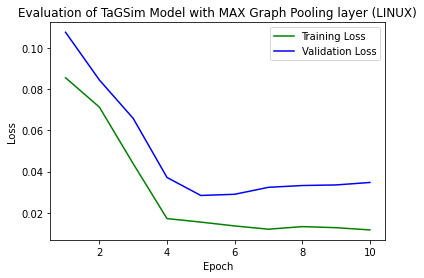


-------Model testing---------.


Model test error: 0.034676592008814365


In [ ]:

model_max = TaGSim_max(Node_Types, Edge_Types, tensor_neurons, bottle_neck_neurons)
title='Evaluation of TaGSim Model with MAX Graph Pooling layer (' + DATASET + ')'
fit(model_max,title)

#Mean


In [ ]:


class TaGSim_mean(torch.nn.Module):
    def __init__(self, number_of_node_labels, number_of_edge_labels, tensor_neurons, bottle_neck_neurons):
        super(TaGSim_mean, self).__init__()
        # self.number_of_node_labels = len(number_of_node_labels)
        # self.number_of_edge_labels = len(number_of_edge_labels)
        self.tensor_neurons = tensor_neurons
        self.bottle_neck_neurons = bottle_neck_neurons
        self.testResult=[]
        self.setup_layers()



    def setup_layers(self):
        self.feature_count = self.tensor_neurons

        # self.tensor_network_nc = TensorNetworkModule(self.tensor_neurons, 2 * self.number_of_node_labels)
        self.tensor_network_in = TensorNetworkModule(self.tensor_neurons, 7)
        # self.tensor_network_ie = TensorNetworkModule(self.tensor_neurons, 2 * self.number_of_node_labels)
        self.tensor_network_ec = TensorNetworkModule(self.tensor_neurons, 23)

        # self.fully_connected_first_nc = torch.nn.Linear(self.feature_count, self.bottle_neck_neurons)
        # self.fully_connected_second_nc = torch.nn.Linear(self.bottle_neck_neurons, 8)
        # self.fully_connected_third_nc = torch.nn.Linear(8, 4)
        # self.scoring_layer_nc = torch.nn.Linear(4, 1)

        self.fully_connected_first_in = torch.nn.Linear(self.feature_count, self.bottle_neck_neurons)
        self.fully_connected_second_in = torch.nn.Linear(self.bottle_neck_neurons, 8)
        self.fully_connected_third_in = torch.nn.Linear(8, 4)
        self.scoring_layer_in = torch.nn.Linear(4, 1)

        # self.fully_connected_first_ie = torch.nn.Linear(self.feature_count, self.bottle_neck_neurons)
        # self.fully_connected_second_ie = torch.nn.Linear(self.bottle_neck_neurons, 8)
        # self.fully_connected_third_ie = torch.nn.Linear(8, 4)
        # self.scoring_layer_ie = torch.nn.Linear(4, 1)

        self.fully_connected_first_ec = torch.nn.Linear(self.feature_count, self.bottle_neck_neurons)
        self.fully_connected_second_ec = torch.nn.Linear(self.bottle_neck_neurons, 8)
        self.fully_connected_third_ec = torch.nn.Linear(8, 4)
        self.scoring_layer_ec = torch.nn.Linear(4, 1)

    def gal_pass(self, edge_index, features):
        hidden1 = graph_aggregation_layer(features, edge_index)
        hidden2 = graph_aggregation_layer(hidden1, edge_index)
        return hidden1, hidden2

    def transform_label_multiset(self, graph_pair, type_specified=True):
        graph1 = graph_pair['graph_pair'][0]
        graph2 = graph_pair['graph_pair'][1]
        ged = graph_pair['ged']

        label_multiset = dict()
        node_features_1, node_features_2= [], []

        for i in graph1.nodes():
            node_features_1.append([1.0])
        for i in graph2.nodes():
            node_features_2.append([1.0])

        node_features_1, node_features_2 = torch.FloatTensor(np.array(node_features_1)), torch.FloatTensor(
            np.array(node_features_2))

        #label_multiset["edge_index_1"], label_multiset["edge_index_2"] = nx.adjacency_matrix(graph1), nx.adjacency_matrix(graph2)
        label_multiset["features_1"], label_multiset["features_2"] = node_features_1, node_features_2

        # label_multiset["node_index_1"], label_multiset["node_index_2"] = nx.adjacency_matrix(
        #     graph1), nx.adjacency_matrix(graph2)
        # label_multiset["node_features_1"], label_multiset["node_features_2"] = node_features_1, node_features_2
        # label_multiset["edge_features_1"], label_multiset["edge_features_2"] = edge_features_1, edge_features_2
        # label_multiset["edge_adj_1"], label_multiset["edge_adj_2"] = edge_adj_1, edge_adj_2

        edges1 = list(graph1.edges())
        edges2 = list(graph2.edges())

        node_features_1, node_features_2, edge_features_1, edge_features_2, edge_adj_1, edge_adj_2 = [], [], [], [], [], []

        for i in graph1.nodes():
            node_features_1.append([1.0  ])
        for i in graph2.nodes():
            node_features_2.append([1.0  ])
            

        for i in edges1:
            edge_features_1.append([1.0 ])
            adj_row = []
            for d in edges1:
                if (i == d):
                    adj_row.append(0.0)
                    continue
                if ((i[0] in d) | (i[1] in d)):
                    adj_row.append(1.0)
                else:
                    adj_row.append(0.0)
            edge_adj_1.append(adj_row)
        for i in edges2:
            edge_features_2.append([1.0  ])
            adj_row = []
            for d in edges2:
                if (i == d):
                    adj_row.append(0.0)
                    continue
                if ((i[0] in d) | (i[1] in d)):
                    adj_row.append(1.0)
                else:
                    adj_row.append(0.0)
            edge_adj_2.append(adj_row)
        edge_features_1, edge_features_2 = torch.FloatTensor(np.array(edge_features_1)), torch.FloatTensor(
            np.array(edge_features_2))
        edge_adj_1, edge_adj_2 = torch.FloatTensor(np.array(edge_adj_1)), torch.FloatTensor(np.array(edge_adj_2))


        label_multiset["edge_features_1"], label_multiset["edge_features_2"] = edge_features_1, edge_features_2
        label_multiset["edge_adj_1"], label_multiset["edge_adj_2"] = edge_adj_1, edge_adj_2

        node_features_1,node_features_2=        nx.adjacency_matrix(graph1).todense(), nx.adjacency_matrix(graph2).todense()
        #label_multiset["edge_index_1"], label_multiset["edge_index_2"] = nx.adjacency_matrix(graph1), nx.adjacency_matrix(graph2)
        label_multiset["node_adj_1"], label_multiset["node_adj_2"] =torch.FloatTensor(np.array(node_features_1)), torch.FloatTensor(
            np.array(node_features_2))
        
        #ged normalisation
        if (type_specified):  # for training
            avg_node_number = 0.5 * (graph1.number_of_nodes() + graph2.number_of_nodes())
            norm_ged = [n / avg_node_number for n in ged]
            norm_ged = np.array(norm_ged)
            label_multiset["target"] = torch.from_numpy(np.exp(-norm_ged)).view(1, -1).float()

            norm_gt_ged = (sum(ged)) / (0.5 * (graph1.number_of_nodes() + graph2.number_of_nodes()))
            label_multiset["gt_ged"] = torch.from_numpy(np.exp(-norm_gt_ged).reshape(1, 1)).view(1, -1).float()
        else:  # for testing
            norm_gt_ged = (ged) / (0.5 * (graph1.number_of_nodes() + graph2.number_of_nodes()))
            label_multiset["gt_ged"] = torch.from_numpy(np.exp(-norm_gt_ged).reshape(1, 1)).view(1, -1).float()

        return label_multiset
    def forward(self, label_multiset):
      adj_1 =  label_multiset["edge_adj_1"]
      adj_2 =  label_multiset["edge_adj_2"] 
      adj_1 =  label_multiset["node_adj_1"]
      adj_2 =  label_multiset["node_adj_2"] 
      features_1, features_2 = label_multiset["features_1"],label_multiset["features_2"]
      edge_adj_1, edge_adj_2 = label_multiset["edge_adj_1"], label_multiset["edge_adj_2"]
      
      edge_features_1, edge_features_2 = label_multiset["edge_features_1"], label_multiset["edge_features_2"]

              
      graph1_hidden1, graph1_hidden2 = self.gal_pass(adj_1, features_1)#
      graph2_hidden1, graph2_hidden2 = self.gal_pass(adj_2, features_2)#
    
      Graph1_hidden1, Graph1_hidden2, Graph2_hidden1, Graph2_hidden2 = [], [], [], []
      for i in range(graph1_hidden1.size()[0]):
        if(graph1_hidden1[i][0] >= 6):# 10 for imdb; 6 for linux # the valus here can be set by the users
            Graph1_hidden1.append([0.0]*5 + [1.0])
        else:
            Graph1_hidden1.append([1.0 if graph1_hidden1[i][0] == j else 0.0 for j in range(6)])

        if(graph1_hidden2[i][0] >= 15):# 50 for imdb; 15 for linux # the valus here can be set by the users
            Graph1_hidden2.append([0.0]*14 + [1.0])
        else:
            Graph1_hidden2.append([1.0 if graph1_hidden2[i][0] == j else 0.0 for j in range(15)])

      for i in range(graph2_hidden1.size()[0]):
          if(graph2_hidden1[i][0] >= 6):# 10 for imdb; 6 for linux # the valus here can be set by the users
              Graph2_hidden1.append([0.0]*5 + [1.0])
          else:
              Graph2_hidden1.append([1.0 if graph2_hidden1[i][0] == j else 0.0 for j in range(6)])

          if(graph2_hidden2[i][0] >= 15):# 50 for imdb; 15 for linux # the valus here can be set by the users
              Graph2_hidden2.append([0.0]*14 + [1.0])
          else:
              Graph2_hidden2.append([1.0 if graph2_hidden2[i][0] == j else 0.0 for j in range(15)])
      Graph1_hidden1, Graph1_hidden2 = torch.FloatTensor(np.array(Graph1_hidden1)), torch.FloatTensor(np.array(Graph1_hidden2))
      Graph2_hidden1, Graph2_hidden2 = torch.FloatTensor(np.array(Graph2_hidden1)), torch.FloatTensor(np.array(Graph2_hidden2))


      edge1_hidden1, edge1_hidden2 = self.gal_pass(edge_adj_1, edge_features_1)  #original edge node
      edge2_hidden1, edge2_hidden2 = self.gal_pass(edge_adj_2, edge_features_2)  #generated graph edge


      graph1_01concat = torch.cat([features_1, Graph1_hidden1], dim=1)
      graph2_01concat = torch.cat([features_2, Graph2_hidden1], dim=1)
      graph1_12concat = torch.cat([Graph1_hidden1, Graph1_hidden2], dim=1)
      graph2_12concat = torch.cat([Graph2_hidden1, Graph2_hidden2], dim=1)
      graph1_01pooled = torch.mean(graph1_01concat, dim=0).unsqueeze(1) 
      graph2_01pooled = torch.mean(graph2_01concat, dim=0).unsqueeze(1)
      graph1_12pooled = torch.mean(graph1_12concat,  dim=0)
      graph2_12pooled = torch.mean(graph2_12concat, dim=0)



      scores_in = self.tensor_network_in(graph1_01pooled, graph2_01pooled)
      scores_in = torch.t(scores_in)

      scores_in = torch.nn.functional.relu(self.fully_connected_first_in(scores_in))
      scores_in = torch.nn.functional.relu(self.fully_connected_second_in(scores_in))
      scores_in = torch.nn.functional.relu(self.fully_connected_third_in(scores_in))
      score_in = torch.sigmoid(self.scoring_layer_in(scores_in))
        #edge level embedding Concatenation
      edge1_01concat = torch.cat([ edge_features_1, edge1_hidden1], dim=1)
      edge2_01concat = torch.cat([ edge_features_2, edge2_hidden1], dim=1)
      #graph pooling: edge Sum
      edge1_01pooled = torch.mean(edge1_01concat, dim=0)
      edge2_01pooled = torch.mean(edge2_01concat, dim=0)

      graph1_ec_input=torch.cat([ graph1_12pooled, edge1_01pooled]).unsqueeze(1)
      graph2_ec_input=torch.cat([ graph2_12pooled, edge2_01pooled]).unsqueeze(1)
      scores_ec = self.tensor_network_ec(graph1_ec_input, graph2_ec_input)
      scores_ec = torch.t(scores_ec)

      scores_ec = torch.nn.functional.relu(self.fully_connected_first_ec(scores_ec))
      scores_ec = torch.nn.functional.relu(self.fully_connected_second_ec(scores_ec))
      scores_ec = torch.nn.functional.relu(self.fully_connected_third_ec(scores_ec))
      score_ec = torch.sigmoid(self.scoring_layer_ec(scores_ec))
                     #edge insert
      return torch.cat([score_in, score_ec], dim=1)



-------Model training---------.

Iteration 0 loss:  0.1280885636806488
Iteration 1 loss:  0.13028603792190552
Iteration 2 loss:  0.12346915900707245
Iteration 3 loss:  0.1263076514005661
Iteration 4 loss:  0.12166304141283035
Iteration 5 loss:  0.12406255304813385
Iteration 6 loss:  0.12139859050512314
Iteration 7 loss:  0.12452176213264465
Iteration 8 loss:  0.12779220938682556
Iteration 9 loss:  0.12254711985588074
Iteration 10 loss:  0.12547490000724792
Iteration 11 loss:  0.1151147335767746
Iteration 12 loss:  0.11991031467914581
Iteration 13 loss:  0.10671505331993103
Iteration 14 loss:  0.11081666499376297
Iteration 15 loss:  0.10972970797691817
Iteration 16 loss:  0.10952020436525345
Iteration 17 loss:  0.10915633291006088
Iteration 18 loss:  0.11682908982038498
Iteration 19 loss:  0.12297962605953217
Iteration 20 loss:  0.1166866272687912
Iteration 21 loss:  0.10310972481966019
Iteration 22 loss:  0.10998811572790146
Iteration 23 loss:  0.10727275907993317
Iteration 24 loss:  

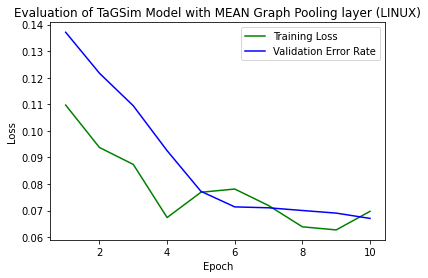


-------Model testing---------.


Model test error: 0.4663929381008659


In [ ]:

import matplotlib.pyplot as plt

epochs = 10
tensor_neurons = 16
bottle_neck_neurons = 16
batch_size = 128
dropout = 0.0
lr = 0.001
weight_decay = 0.0

Node_Types = ['1']
Edge_Types = ['1']
#collection global node label and edge label info

print("\n-------Model training---------.\n")

model = TaGSim_mean(Node_Types, Edge_Types, tensor_neurons, bottle_neck_neurons)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
iteration = 0

visual_loss_train = []
visual_loss_test = []
train_pair = []
test_pair = []
epo = []
#model training
for epoch in range(epochs):
  
    random.shuffle(train_pairs)
    batches = []
    for graph in range(0, len(train_pairs), batch_size):
        batches.append(train_pairs[graph:graph + batch_size])

    for batch in batches:
        model.train()
        optimizer.zero_grad()
        losses = 0
        for graph_pair in batch:
            data = model.transform_label_multiset(graph_pair)
            prediction = model(data)
            losses += torch.nn.functional.mse_loss(data["target"], prediction)

        losses.backward(retain_graph=True)
        optimizer.step()
        loss = losses.item()
        print('Iteration', iteration, 'loss: ', loss / len(batch))
        iteration += 1

    visual_loss_train.append(loss / len(batch))


    # testing
    model.eval()
    test_scores=[]
    for n in test_pairs:
        graph1 = n['graph_pair'][0]  #updated_test
        graph2 = n['graph_pair'][1]  #updated_test
        ged = int(n['gt_ged'])
        tem_data = {"graph_pair": [graph1, graph2], "ged": ged}
        data = model.transform_label_multiset(tem_data, type_specified=False)
        prediction = model(data)
        prediction = torch.exp(torch.sum(torch.log(prediction))).view(1, -1)
        current_error = torch.nn.functional.mse_loss(prediction, data["gt_ged"])
        test_scores.append(current_error.data.item())
    visual_loss_test.append(sum(test_scores) / len(test_scores))
    epo.append(epoch + 1)


#visualization of traning and testing loss
plt.plot(epo, visual_loss_train, 'g', label='Training Loss')
plt.plot(epo, visual_loss_test, 'b', label='Validation Error Rate')
plt.title('Evaluation of TaGSim Model with MEAN Graph Pooling layer (' + DATASET + ')')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

print("\n-------Model testing---------.\n")

model.eval()
test_scores = []
for n in test_pairs:
    graph1 = n['graph_pair'][0]  #updated_test
    graph2 = n['graph_pair'][1]  #updated_test
    ged = int(n['gt_ged'])
    tem_data = {"graph_pair": [graph1, graph2], "ged": ged}
    data = model.transform_label_multiset(tem_data, type_specified=False)
    prediction = model(data)
    #prediction = torch.exp(torch.sum(torch.log(prediction))).view(1, -1)
    prediction = torch.sum(prediction).view(1, -1)
    current_error = torch.nn.functional.mse_loss(prediction, data["gt_ged"])
    test_scores.append(current_error.data.item())

model_error = sum(test_scores) / len(test_scores)
print("\nModel test error: " + str(model_error))

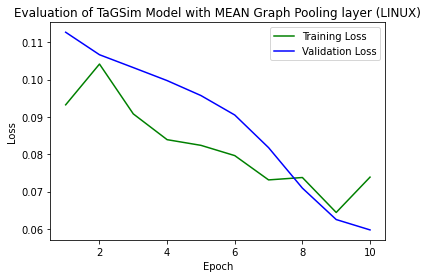


-------Model testing---------.


Model test error: 0.05972962696812049


In [ ]:

model = TaGSim_mean(Node_Types, Edge_Types, tensor_neurons, bottle_neck_neurons)
title='Evaluation of TaGSim Model with MEAN Graph Pooling layer (' + DATASET + ')'
fit(model,title)

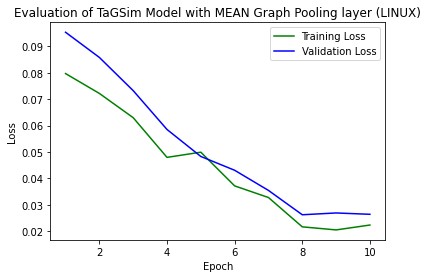


-------Model testing---------.


Model test error: 0.026365475569186208


In [ ]:

model = TaGSim_mean(Node_Types, Edge_Types, tensor_neurons, bottle_neck_neurons)
title='Evaluation of TaGSim Model with MEAN Graph Pooling layer (' + DATASET + ')'
fit(model,title)

#MIN

In [ ]:


class TaGSim_min(torch.nn.Module):
    def __init__(self, number_of_node_labels, number_of_edge_labels, tensor_neurons, bottle_neck_neurons):
        super(TaGSim_min, self).__init__()
        # self.number_of_node_labels = len(number_of_node_labels)
        # self.number_of_edge_labels = len(number_of_edge_labels)
        self.tensor_neurons = tensor_neurons
        self.bottle_neck_neurons = bottle_neck_neurons
        self.testResult=[]
        self.setup_layers()



    def setup_layers(self):
        self.feature_count = self.tensor_neurons

        # self.tensor_network_nc = TensorNetworkModule(self.tensor_neurons, 2 * self.number_of_node_labels)
        self.tensor_network_in = TensorNetworkModule(self.tensor_neurons, 7)
        # self.tensor_network_ie = TensorNetworkModule(self.tensor_neurons, 2 * self.number_of_node_labels)
        self.tensor_network_ec = TensorNetworkModule(self.tensor_neurons, 23)

        # self.fully_connected_first_nc = torch.nn.Linear(self.feature_count, self.bottle_neck_neurons)
        # self.fully_connected_second_nc = torch.nn.Linear(self.bottle_neck_neurons, 8)
        # self.fully_connected_third_nc = torch.nn.Linear(8, 4)
        # self.scoring_layer_nc = torch.nn.Linear(4, 1)

        self.fully_connected_first_in = torch.nn.Linear(self.feature_count, self.bottle_neck_neurons)
        self.fully_connected_second_in = torch.nn.Linear(self.bottle_neck_neurons, 8)
        self.fully_connected_third_in = torch.nn.Linear(8, 4)
        self.scoring_layer_in = torch.nn.Linear(4, 1)

        # self.fully_connected_first_ie = torch.nn.Linear(self.feature_count, self.bottle_neck_neurons)
        # self.fully_connected_second_ie = torch.nn.Linear(self.bottle_neck_neurons, 8)
        # self.fully_connected_third_ie = torch.nn.Linear(8, 4)
        # self.scoring_layer_ie = torch.nn.Linear(4, 1)

        self.fully_connected_first_ec = torch.nn.Linear(self.feature_count, self.bottle_neck_neurons)
        self.fully_connected_second_ec = torch.nn.Linear(self.bottle_neck_neurons, 8)
        self.fully_connected_third_ec = torch.nn.Linear(8, 4)
        self.scoring_layer_ec = torch.nn.Linear(4, 1)

    def gal_pass(self, edge_index, features):
        hidden1 = graph_aggregation_layer(features, edge_index)
        hidden2 = graph_aggregation_layer(hidden1, edge_index)
        return hidden1, hidden2

    def transform_label_multiset(self, graph_pair, type_specified=True):
        graph1 = graph_pair['graph_pair'][0]
        graph2 = graph_pair['graph_pair'][1]
        ged = graph_pair['ged']

        label_multiset = dict()
        node_features_1, node_features_2= [], []

        for i in graph1.nodes():
            node_features_1.append([1.0])
        for i in graph2.nodes():
            node_features_2.append([1.0])

        node_features_1, node_features_2 = torch.FloatTensor(np.array(node_features_1)), torch.FloatTensor(
            np.array(node_features_2))

        #label_multiset["edge_index_1"], label_multiset["edge_index_2"] = nx.adjacency_matrix(graph1), nx.adjacency_matrix(graph2)
        label_multiset["features_1"], label_multiset["features_2"] = node_features_1, node_features_2

        # label_multiset["node_index_1"], label_multiset["node_index_2"] = nx.adjacency_matrix(
        #     graph1), nx.adjacency_matrix(graph2)
        # label_multiset["node_features_1"], label_multiset["node_features_2"] = node_features_1, node_features_2
        # label_multiset["edge_features_1"], label_multiset["edge_features_2"] = edge_features_1, edge_features_2
        # label_multiset["edge_adj_1"], label_multiset["edge_adj_2"] = edge_adj_1, edge_adj_2

        edges1 = list(graph1.edges())
        edges2 = list(graph2.edges())

        node_features_1, node_features_2, edge_features_1, edge_features_2, edge_adj_1, edge_adj_2 = [], [], [], [], [], []

        for i in graph1.nodes():
            node_features_1.append([1.0  ])
        for i in graph2.nodes():
            node_features_2.append([1.0  ])
            

        for i in edges1:
            edge_features_1.append([1.0 ])
            adj_row = []
            for d in edges1:
                if (i == d):
                    adj_row.append(0.0)
                    continue
                if ((i[0] in d) | (i[1] in d)):
                    adj_row.append(1.0)
                else:
                    adj_row.append(0.0)
            edge_adj_1.append(adj_row)
        for i in edges2:
            edge_features_2.append([1.0  ])
            adj_row = []
            for d in edges2:
                if (i == d):
                    adj_row.append(0.0)
                    continue
                if ((i[0] in d) | (i[1] in d)):
                    adj_row.append(1.0)
                else:
                    adj_row.append(0.0)
            edge_adj_2.append(adj_row)
        edge_features_1, edge_features_2 = torch.FloatTensor(np.array(edge_features_1)), torch.FloatTensor(
            np.array(edge_features_2))
        edge_adj_1, edge_adj_2 = torch.FloatTensor(np.array(edge_adj_1)), torch.FloatTensor(np.array(edge_adj_2))


        label_multiset["edge_features_1"], label_multiset["edge_features_2"] = edge_features_1, edge_features_2
        label_multiset["edge_adj_1"], label_multiset["edge_adj_2"] = edge_adj_1, edge_adj_2

        node_features_1,node_features_2=        nx.adjacency_matrix(graph1).todense(), nx.adjacency_matrix(graph2).todense()
        #label_multiset["edge_index_1"], label_multiset["edge_index_2"] = nx.adjacency_matrix(graph1), nx.adjacency_matrix(graph2)
        label_multiset["node_adj_1"], label_multiset["node_adj_2"] =torch.FloatTensor(np.array(node_features_1)), torch.FloatTensor(
            np.array(node_features_2))
        
        #ged normalisation
        if (type_specified):  # for training
            avg_node_number = 0.5 * (graph1.number_of_nodes() + graph2.number_of_nodes())
            norm_ged = [n / avg_node_number for n in ged]
            norm_ged = np.array(norm_ged)
            label_multiset["target"] = torch.from_numpy(np.exp(-norm_ged)).view(1, -1).float()

            norm_gt_ged = (sum(ged)) / (0.5 * (graph1.number_of_nodes() + graph2.number_of_nodes()))
            label_multiset["gt_ged"] = torch.from_numpy(np.exp(-norm_gt_ged).reshape(1, 1)).view(1, -1).float()
        else:  # for testing
            norm_gt_ged = (ged) / (0.5 * (graph1.number_of_nodes() + graph2.number_of_nodes()))
            label_multiset["gt_ged"] = torch.from_numpy(np.exp(-norm_gt_ged).reshape(1, 1)).view(1, -1).float()

        return label_multiset
    def forward(self, label_multiset):
      adj_1 =  label_multiset["edge_adj_1"]
      adj_2 =  label_multiset["edge_adj_2"] 
      adj_1 =  label_multiset["node_adj_1"]
      adj_2 =  label_multiset["node_adj_2"] 
      features_1, features_2 = label_multiset["features_1"],label_multiset["features_2"]
      edge_adj_1, edge_adj_2 = label_multiset["edge_adj_1"], label_multiset["edge_adj_2"]
      
      edge_features_1, edge_features_2 = label_multiset["edge_features_1"], label_multiset["edge_features_2"]

              
      graph1_hidden1, graph1_hidden2 = self.gal_pass(adj_1, features_1)#
      graph2_hidden1, graph2_hidden2 = self.gal_pass(adj_2, features_2)#
    
      Graph1_hidden1, Graph1_hidden2, Graph2_hidden1, Graph2_hidden2 = [], [], [], []
      for i in range(graph1_hidden1.size()[0]):
        if(graph1_hidden1[i][0] >= 6):# 10 for imdb; 6 for linux # the valus here can be set by the users
            Graph1_hidden1.append([0.0]*5 + [1.0])
        else:
            Graph1_hidden1.append([1.0 if graph1_hidden1[i][0] == j else 0.0 for j in range(6)])

        if(graph1_hidden2[i][0] >= 15):# 50 for imdb; 15 for linux # the valus here can be set by the users
            Graph1_hidden2.append([0.0]*14 + [1.0])
        else:
            Graph1_hidden2.append([1.0 if graph1_hidden2[i][0] == j else 0.0 for j in range(15)])

      for i in range(graph2_hidden1.size()[0]):
          if(graph2_hidden1[i][0] >= 6):# 10 for imdb; 6 for linux # the valus here can be set by the users
              Graph2_hidden1.append([0.0]*5 + [1.0])
          else:
              Graph2_hidden1.append([1.0 if graph2_hidden1[i][0] == j else 0.0 for j in range(6)])

          if(graph2_hidden2[i][0] >= 15):# 50 for imdb; 15 for linux # the valus here can be set by the users
              Graph2_hidden2.append([0.0]*14 + [1.0])
          else:
              Graph2_hidden2.append([1.0 if graph2_hidden2[i][0] == j else 0.0 for j in range(15)])
      Graph1_hidden1, Graph1_hidden2 = torch.FloatTensor(np.array(Graph1_hidden1)), torch.FloatTensor(np.array(Graph1_hidden2))
      Graph2_hidden1, Graph2_hidden2 = torch.FloatTensor(np.array(Graph2_hidden1)), torch.FloatTensor(np.array(Graph2_hidden2))


      edge1_hidden1, edge1_hidden2 = self.gal_pass(edge_adj_1, edge_features_1)  #original edge node
      edge2_hidden1, edge2_hidden2 = self.gal_pass(edge_adj_2, edge_features_2)  #generated graph edge


      graph1_01concat = torch.cat([features_1, Graph1_hidden1], dim=1)
      graph2_01concat = torch.cat([features_2, Graph2_hidden1], dim=1)
      graph1_12concat = torch.cat([Graph1_hidden1, Graph1_hidden2], dim=1)
      graph2_12concat = torch.cat([Graph2_hidden1, Graph2_hidden2], dim=1)

      graph1_01pooled = torch.min(graph1_01concat, dim=0).values.unsqueeze(1)

      graph2_01pooled = torch.min(graph2_01concat, dim=0).values.unsqueeze(1)
      graph1_12pooled = torch.min(graph1_12concat,  dim=0).values
      graph2_12pooled = torch.min(graph2_12concat, dim=0).values



      scores_in = self.tensor_network_in(graph1_01pooled, graph2_01pooled)
      scores_in = torch.t(scores_in)

      scores_in = torch.nn.functional.relu(self.fully_connected_first_in(scores_in))
      scores_in = torch.nn.functional.relu(self.fully_connected_second_in(scores_in))
      scores_in = torch.nn.functional.relu(self.fully_connected_third_in(scores_in))
      score_in = torch.sigmoid(self.scoring_layer_in(scores_in))
        #edge level embedding Concatenation
      edge1_01concat = torch.cat([ edge_features_1, edge1_hidden1], dim=1)
      edge2_01concat = torch.cat([ edge_features_2, edge2_hidden1], dim=1)
      #graph pooling: edge Sum
      edge1_01pooled = torch.min(edge1_01concat, dim=0).values
      edge2_01pooled = torch.min(edge2_01concat, dim=0).values

      graph1_ec_input=torch.cat([ graph1_12pooled, edge1_01pooled]).unsqueeze(1)
      graph2_ec_input=torch.cat([ graph2_12pooled, edge2_01pooled]).unsqueeze(1)
      scores_ec = self.tensor_network_ec(graph1_ec_input, graph2_ec_input)
      scores_ec = torch.t(scores_ec)

      scores_ec = torch.nn.functional.relu(self.fully_connected_first_ec(scores_ec))
      scores_ec = torch.nn.functional.relu(self.fully_connected_second_ec(scores_ec))
      scores_ec = torch.nn.functional.relu(self.fully_connected_third_ec(scores_ec))
      score_ec = torch.sigmoid(self.scoring_layer_ec(scores_ec))
                     #edge insert
      return torch.cat([score_in, score_ec], dim=1)


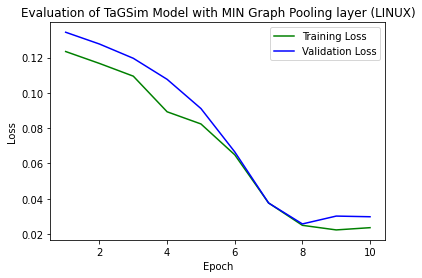


-------Model testing---------.


Model test error: 0.029752426140450032


In [ ]:

model = TaGSim_min(Node_Types, Edge_Types, tensor_neurons, bottle_neck_neurons)
title='Evaluation of TaGSim Model with MIN Graph Pooling layer (' + DATASET + ')'
fit(model,title)

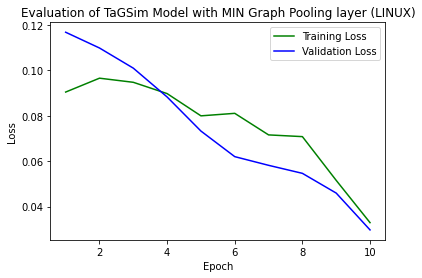


-------Model testing---------.


Model test error: 0.029760801000260732


In [ ]:

model_min = TaGSim_min(Node_Types, Edge_Types, tensor_neurons, bottle_neck_neurons)
title='Evaluation of TaGSim Model with MIN Graph Pooling layer (' + DATASET + ')'
fit(model_min,title)

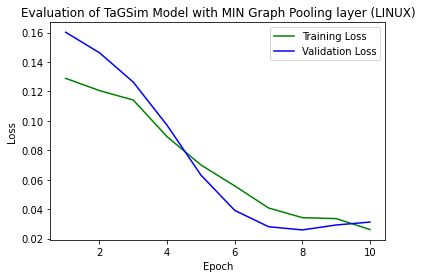


-------Model testing---------.


Model test error: 0.03123476058639686


In [ ]:

model_min = TaGSim_min(Node_Types, Edge_Types, tensor_neurons, bottle_neck_neurons)
title='Evaluation of TaGSim Model with MIN Graph Pooling layer (' + DATASET + ')'
fit(model_min,title)


-------Model training---------.

Iteration 0 loss:  0.15980687737464905
Iteration 1 loss:  0.15998496115207672
Iteration 2 loss:  0.15487737953662872
Iteration 3 loss:  0.14784619212150574
Iteration 4 loss:  0.1399659961462021
Iteration 5 loss:  0.15961608290672302
Iteration 6 loss:  0.15883229672908783
Iteration 7 loss:  0.15978004038333893
Iteration 8 loss:  0.14787925779819489
Iteration 9 loss:  0.13558343052864075
Iteration 10 loss:  0.1588415652513504
Iteration 11 loss:  0.14973902702331543
Iteration 12 loss:  0.14969493448734283
Iteration 13 loss:  0.14252500236034393
Iteration 14 loss:  0.13572461903095245
Iteration 15 loss:  0.1394375341909903
Iteration 16 loss:  0.1492612510919571
Iteration 17 loss:  0.15430289506912231
Iteration 18 loss:  0.1457889825105667
Iteration 19 loss:  0.14754582941532135
Iteration 20 loss:  0.14333175122737885
Iteration 21 loss:  0.14658090472221375
Iteration 22 loss:  0.1322086900472641
Iteration 23 loss:  0.1416110247373581
Iteration 24 loss:  0.1

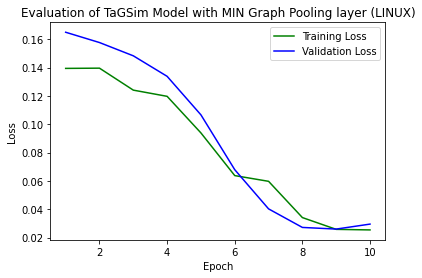


-------Model testing---------.


Model test error: 1.0758048934595925


In [ ]:

import matplotlib.pyplot as plt

epochs = 10
tensor_neurons = 16
bottle_neck_neurons = 16
batch_size = 128
dropout = 0.0
lr = 0.001
weight_decay = 0.0

Node_Types = ['1']
Edge_Types = ['1']
#collection global node label and edge label info

print("\n-------Model training---------.\n")

model = TaGSim_min(Node_Types, Edge_Types, tensor_neurons, bottle_neck_neurons)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
iteration = 0

visual_loss_train = []
visual_loss_test = []
train_pair = []
test_pair = []
epo = []
#model training
for epoch in range(epochs):
  
    random.shuffle(train_pairs)
    batches = []
    for graph in range(0, len(train_pairs), batch_size):
        batches.append(train_pairs[graph:graph + batch_size])

    for batch in batches:
        model.train()
        optimizer.zero_grad()
        losses = 0
        for graph_pair in batch:
            data = model.transform_label_multiset(graph_pair)
            prediction = model(data)
            losses += torch.nn.functional.mse_loss(data["target"], prediction)

        losses.backward(retain_graph=True)
        optimizer.step()
        loss = losses.item()
        print('Iteration', iteration, 'loss: ', loss / len(batch))
        iteration += 1

    visual_loss_train.append(loss / len(batch))


    # testing
    model.eval()
    test_scores=[]
    for n in test_pairs:
        graph1 = n['graph_pair'][0]  #updated_test
        graph2 = n['graph_pair'][1]  #updated_test
        ged = int(n['gt_ged'])
        tem_data = {"graph_pair": [graph1, graph2], "ged": ged}
        data = model.transform_label_multiset(tem_data, type_specified=False)
        prediction = model(data)
        prediction = torch.exp(torch.sum(torch.log(prediction))).view(1, -1)
        current_error = torch.nn.functional.mse_loss(prediction, data["gt_ged"])
        test_scores.append(current_error.data.item())
    visual_loss_test.append(sum(test_scores) / len(test_scores))
    epo.append(epoch + 1)


#visualization of traning and testing loss
plt.plot(epo, visual_loss_train, 'g', label='Training Loss')
plt.plot(epo, visual_loss_test, 'b', label='Validation Error Rate')
plt.title('Evaluation of TaGSim Model with MIN Graph Pooling layer (' + DATASET + ')')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

print("\n-------Model testing---------.\n")

model.eval()
test_scores = []
for n in test_pairs:
    graph1 = n['graph_pair'][0]  #updated_test
    graph2 = n['graph_pair'][1]  #updated_test
    ged = int(n['gt_ged'])
    tem_data = {"graph_pair": [graph1, graph2], "ged": ged}
    data = model.transform_label_multiset(tem_data, type_specified=False)
    prediction = model(data)
    #prediction = torch.exp(torch.sum(torch.log(prediction))).view(1, -1)
    prediction = torch.sum(prediction).view(1, -1)
    current_error = torch.nn.functional.mse_loss(prediction, data["gt_ged"])
    test_scores.append(current_error.data.item())

model_error = sum(test_scores) / len(test_scores)
print("\nModel test error: " + str(model_error))

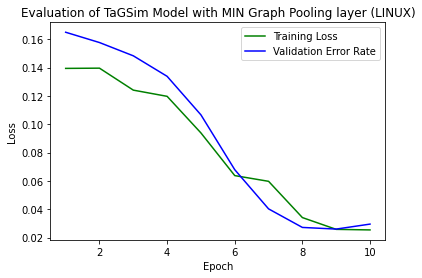

In [ ]:


#visualization of traning and testing loss
plt.plot(epo, visual_loss_train, 'g', label='Training Loss')
plt.plot(epo, visual_loss_test, 'b', label='Validation Error Rate')
plt.title('Evaluation of TaGSim Model with MIN Graph Pooling layer (' + DATASET + ')')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:

model = TaGSim_min(Node_Types, Edge_Types, tensor_neurons, bottle_neck_neurons)
title='Evaluation of TaGSim Model with MIN Graph Pooling layer (' + DATASET + ')'
fit(model,title)

# Base model

In [ ]:
import torch
import numpy as np


class TensorNetworkModule(torch.nn.Module):
    def __init__(self, tensor_neurons, input_dim):
        super(TensorNetworkModule, self).__init__()
        self.input_dim = input_dim
        self.tensor_neurons = tensor_neurons
        self.setup_weights()
        self.init_parameters()

    def setup_weights(self):
        self.weight_matrix = torch.nn.Parameter(torch.Tensor(self.input_dim, self.input_dim, self.tensor_neurons))
        self.weight_matrix_block = torch.nn.Parameter(torch.Tensor(self.tensor_neurons, 2 * self.input_dim))
        self.bias = torch.nn.Parameter(torch.Tensor(self.tensor_neurons, 1))

    def init_parameters(self):
        torch.nn.init.xavier_uniform_(self.weight_matrix)
        torch.nn.init.xavier_uniform_(self.weight_matrix_block)
        torch.nn.init.xavier_uniform_(self.bias)

    def forward(self, embedding_1, embedding_2):
        scoring = torch.mm(torch.t(embedding_1), self.weight_matrix.view(self.input_dim, -1))
        scoring = scoring.view(self.input_dim, self.tensor_neurons)
        scoring = torch.mm(torch.t(scoring), embedding_2)
        combined_representation = torch.cat((embedding_1, embedding_2))
        block_scoring = torch.mm(self.weight_matrix_block, combined_representation)
        scores = torch.nn.functional.relu(scoring + block_scoring + self.bias)
        return scores


def graph_aggregation_layer(input, adj):
    result = torch.mm(adj, input)
    return result


class TaGSim(torch.nn.Module):
    def __init__(self, number_of_node_labels, number_of_edge_labels, tensor_neurons, bottle_neck_neurons):
        super(TaGSim, self).__init__()
        # self.number_of_node_labels = len(number_of_node_labels)
        # self.number_of_edge_labels = len(number_of_edge_labels)
        self.tensor_neurons = tensor_neurons
        self.bottle_neck_neurons = bottle_neck_neurons
        self.setup_layers()



    def setup_layers(self):
        self.feature_count = self.tensor_neurons

        # self.tensor_network_nc = TensorNetworkModule(self.tensor_neurons, 2 * self.number_of_node_labels)
        self.tensor_network_in = TensorNetworkModule(self.tensor_neurons, 7)
        # self.tensor_network_ie = TensorNetworkModule(self.tensor_neurons, 2 * self.number_of_node_labels)
        self.tensor_network_ec = TensorNetworkModule(self.tensor_neurons, 23)

        # self.fully_connected_first_nc = torch.nn.Linear(self.feature_count, self.bottle_neck_neurons)
        # self.fully_connected_second_nc = torch.nn.Linear(self.bottle_neck_neurons, 8)
        # self.fully_connected_third_nc = torch.nn.Linear(8, 4)
        # self.scoring_layer_nc = torch.nn.Linear(4, 1)

        self.fully_connected_first_in = torch.nn.Linear(self.feature_count, self.bottle_neck_neurons)
        self.fully_connected_second_in = torch.nn.Linear(self.bottle_neck_neurons, 8)
        self.fully_connected_third_in = torch.nn.Linear(8, 4)
        self.scoring_layer_in = torch.nn.Linear(4, 1)

        # self.fully_connected_first_ie = torch.nn.Linear(self.feature_count, self.bottle_neck_neurons)
        # self.fully_connected_second_ie = torch.nn.Linear(self.bottle_neck_neurons, 8)
        # self.fully_connected_third_ie = torch.nn.Linear(8, 4)
        # self.scoring_layer_ie = torch.nn.Linear(4, 1)

        self.fully_connected_first_ec = torch.nn.Linear(self.feature_count, self.bottle_neck_neurons)
        self.fully_connected_second_ec = torch.nn.Linear(self.bottle_neck_neurons, 8)
        self.fully_connected_third_ec = torch.nn.Linear(8, 4)
        self.scoring_layer_ec = torch.nn.Linear(4, 1)

    def gal_pass(self, edge_index, features):
        hidden1 = graph_aggregation_layer(features, edge_index)
        hidden2 = graph_aggregation_layer(hidden1, edge_index)
        return hidden1, hidden2

    def transform_label_multiset(self, graph_pair, type_specified=True):
        graph1 = graph_pair['graph_pair'][0]
        graph2 = graph_pair['graph_pair'][1]
        ged = graph_pair['ged']

        label_multiset = dict()
        node_features_1, node_features_2= [], []

        for i in graph1.nodes():
            node_features_1.append([1.0])
        for i in graph2.nodes():
            node_features_2.append([1.0])

        node_features_1, node_features_2 = torch.FloatTensor(np.array(node_features_1)), torch.FloatTensor(
            np.array(node_features_2))

        #label_multiset["edge_index_1"], label_multiset["edge_index_2"] = nx.adjacency_matrix(graph1), nx.adjacency_matrix(graph2)
        label_multiset["features_1"], label_multiset["features_2"] = node_features_1, node_features_2

        # label_multiset["node_index_1"], label_multiset["node_index_2"] = nx.adjacency_matrix(
        #     graph1), nx.adjacency_matrix(graph2)
        # label_multiset["node_features_1"], label_multiset["node_features_2"] = node_features_1, node_features_2
        # label_multiset["edge_features_1"], label_multiset["edge_features_2"] = edge_features_1, edge_features_2
        # label_multiset["edge_adj_1"], label_multiset["edge_adj_2"] = edge_adj_1, edge_adj_2

        edges1 = list(graph1.edges())
        edges2 = list(graph2.edges())

        node_features_1, node_features_2, edge_features_1, edge_features_2, edge_adj_1, edge_adj_2 = [], [], [], [], [], []

        for i in graph1.nodes():
            node_features_1.append([1.0  ])
        for i in graph2.nodes():
            node_features_2.append([1.0  ])
            

        for i in edges1:
            edge_features_1.append([1.0 ])
            adj_row = []
            for d in edges1:
                if (i == d):
                    adj_row.append(0.0)
                    continue
                if ((i[0] in d) | (i[1] in d)):
                    adj_row.append(1.0)
                else:
                    adj_row.append(0.0)
            edge_adj_1.append(adj_row)
        for i in edges2:
            edge_features_2.append([1.0  ])
            adj_row = []
            for d in edges2:
                if (i == d):
                    adj_row.append(0.0)
                    continue
                if ((i[0] in d) | (i[1] in d)):
                    adj_row.append(1.0)
                else:
                    adj_row.append(0.0)
            edge_adj_2.append(adj_row)
        edge_features_1, edge_features_2 = torch.FloatTensor(np.array(edge_features_1)), torch.FloatTensor(
            np.array(edge_features_2))
        edge_adj_1, edge_adj_2 = torch.FloatTensor(np.array(edge_adj_1)), torch.FloatTensor(np.array(edge_adj_2))


        label_multiset["edge_features_1"], label_multiset["edge_features_2"] = edge_features_1, edge_features_2
        label_multiset["edge_adj_1"], label_multiset["edge_adj_2"] = edge_adj_1, edge_adj_2

        node_features_1,node_features_2=        nx.adjacency_matrix(graph1).todense(), nx.adjacency_matrix(graph2).todense()
        #label_multiset["edge_index_1"], label_multiset["edge_index_2"] = nx.adjacency_matrix(graph1), nx.adjacency_matrix(graph2)
        label_multiset["node_adj_1"], label_multiset["node_adj_2"] =torch.FloatTensor(np.array(node_features_1)), torch.FloatTensor(
            np.array(node_features_2))
        
        #ged normalisation
        if (type_specified):  # for training
            avg_node_number = 0.5 * (graph1.number_of_nodes() + graph2.number_of_nodes())
            norm_ged = [n / avg_node_number for n in ged]
            norm_ged = np.array(norm_ged)
            label_multiset["target"] = torch.from_numpy(np.exp(-norm_ged)).view(1, -1).float()

            norm_gt_ged = (sum(ged)) / (0.5 * (graph1.number_of_nodes() + graph2.number_of_nodes()))
            label_multiset["gt_ged"] = torch.from_numpy(np.exp(-norm_gt_ged).reshape(1, 1)).view(1, -1).float()
        else:  # for testing
            norm_gt_ged = (ged) / (0.5 * (graph1.number_of_nodes() + graph2.number_of_nodes()))
            label_multiset["gt_ged"] = torch.from_numpy(np.exp(-norm_gt_ged).reshape(1, 1)).view(1, -1).float()

        return label_multiset
    def forward(self, label_multiset):
      adj_1 =  label_multiset["edge_adj_1"]
      adj_2 =  label_multiset["edge_adj_2"] 
      adj_1 =  label_multiset["node_adj_1"]
      adj_2 =  label_multiset["node_adj_2"] 
      features_1, features_2 = label_multiset["features_1"],label_multiset["features_2"]
      edge_adj_1, edge_adj_2 = label_multiset["edge_adj_1"], label_multiset["edge_adj_2"]
      
      edge_features_1, edge_features_2 = label_multiset["edge_features_1"], label_multiset["edge_features_2"]

              
      graph1_hidden1, graph1_hidden2 = self.gal_pass(adj_1, features_1)#
      graph2_hidden1, graph2_hidden2 = self.gal_pass(adj_2, features_2)#
    
      Graph1_hidden1, Graph1_hidden2, Graph2_hidden1, Graph2_hidden2 = [], [], [], []
      for i in range(graph1_hidden1.size()[0]):
        if(graph1_hidden1[i][0] >= 6):# 10 for imdb; 6 for linux # the valus here can be set by the users
            Graph1_hidden1.append([0.0]*5 + [1.0])
        else:
            Graph1_hidden1.append([1.0 if graph1_hidden1[i][0] == j else 0.0 for j in range(6)])

        if(graph1_hidden2[i][0] >= 15):# 50 for imdb; 15 for linux # the valus here can be set by the users
            Graph1_hidden2.append([0.0]*14 + [1.0])
        else:
            Graph1_hidden2.append([1.0 if graph1_hidden2[i][0] == j else 0.0 for j in range(15)])

      for i in range(graph2_hidden1.size()[0]):
          if(graph2_hidden1[i][0] >= 6):# 10 for imdb; 6 for linux # the valus here can be set by the users
              Graph2_hidden1.append([0.0]*5 + [1.0])
          else:
              Graph2_hidden1.append([1.0 if graph2_hidden1[i][0] == j else 0.0 for j in range(6)])

          if(graph2_hidden2[i][0] >= 15):# 50 for imdb; 15 for linux # the valus here can be set by the users
              Graph2_hidden2.append([0.0]*14 + [1.0])
          else:
              Graph2_hidden2.append([1.0 if graph2_hidden2[i][0] == j else 0.0 for j in range(15)])
      Graph1_hidden1, Graph1_hidden2 = torch.FloatTensor(np.array(Graph1_hidden1)), torch.FloatTensor(np.array(Graph1_hidden2))
      Graph2_hidden1, Graph2_hidden2 = torch.FloatTensor(np.array(Graph2_hidden1)), torch.FloatTensor(np.array(Graph2_hidden2))


      edge1_hidden1, edge1_hidden2 = self.gal_pass(edge_adj_1, edge_features_1)  #original edge node
      edge2_hidden1, edge2_hidden2 = self.gal_pass(edge_adj_2, edge_features_2)  #generated graph edge


      graph1_01concat = torch.cat([features_1, Graph1_hidden1], dim=1)
      graph2_01concat = torch.cat([features_2, Graph2_hidden1], dim=1)
      graph1_12concat = torch.cat([Graph1_hidden1, Graph1_hidden2], dim=1)
      graph2_12concat = torch.cat([Graph2_hidden1, Graph2_hidden2], dim=1)
        #edge level embedding Concatenation
      edge1_01concat = torch.cat([ edge_features_1, edge1_hidden1], dim=1)
      edge2_01concat = torch.cat([ edge_features_2, edge2_hidden1], dim=1)
      #graph pooling: edge Sum
      edge1_01pooled = torch.sum(edge1_01concat, dim=0)
      edge2_01pooled = torch.sum(edge2_01concat, dim=0)

      graph1_01pooled = torch.sum(graph1_01concat, dim=0).unsqueeze(1)# default: sum
      graph2_01pooled = torch.sum(graph2_01concat, dim=0).unsqueeze(1)
      graph1_12pooled = torch.sum(graph1_12concat, dim=0)
      graph2_12pooled = torch.sum(graph2_12concat, dim=0)



      scores_in = self.tensor_network_in(graph1_01pooled, graph2_01pooled)
      scores_in = torch.t(scores_in)

      scores_in = torch.nn.functional.relu(self.fully_connected_first_in(scores_in))
      scores_in = torch.nn.functional.relu(self.fully_connected_second_in(scores_in))
      scores_in = torch.nn.functional.relu(self.fully_connected_third_in(scores_in))
      score_in = torch.sigmoid(self.scoring_layer_in(scores_in))

      graph1_ec_input=torch.cat([ graph1_12pooled, edge1_01pooled]).unsqueeze(1)
      graph2_ec_input=torch.cat([ graph2_12pooled, edge2_01pooled]).unsqueeze(1)
      scores_ec = self.tensor_network_ec(graph1_ec_input, graph2_ec_input)
      scores_ec = torch.t(scores_ec)

      scores_ec = torch.nn.functional.relu(self.fully_connected_first_ec(scores_ec))
      scores_ec = torch.nn.functional.relu(self.fully_connected_second_ec(scores_ec))
      scores_ec = torch.nn.functional.relu(self.fully_connected_third_ec(scores_ec))
      score_ec = torch.sigmoid(self.scoring_layer_ec(scores_ec))
                     #edge insert
      return torch.cat([score_in, score_ec], dim=1)



-------Model training---------.

Iteration 0 loss:  0.2783595323562622
Iteration 1 loss:  0.273190975189209
Iteration 2 loss:  0.24941961467266083
Iteration 3 loss:  0.2483978122472763
Iteration 4 loss:  0.2307378053665161
Iteration 5 loss:  0.2640029191970825
Iteration 6 loss:  0.2366073578596115
Iteration 7 loss:  0.23635783791542053
Iteration 8 loss:  0.24274799227714539
Iteration 9 loss:  0.20429596304893494
Iteration 10 loss:  0.1960410177707672
Iteration 11 loss:  0.1845693141222
Iteration 12 loss:  0.18269935250282288
Iteration 13 loss:  0.17358043789863586
Iteration 14 loss:  0.16751323640346527
Iteration 15 loss:  0.15339574696105204
Iteration 16 loss:  0.11378323286771774
Iteration 17 loss:  0.12709853053092957
Iteration 18 loss:  0.1183062344789505
Iteration 19 loss:  0.10146712511777878
Iteration 20 loss:  0.0987432673573494
Iteration 21 loss:  0.09777406603097916
Iteration 22 loss:  0.10594570636749268
Iteration 23 loss:  0.09782090038061142
Iteration 24 loss:  0.11758738

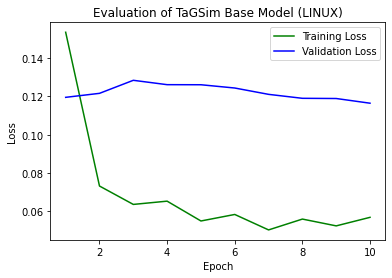


-------Model testing---------.


Model test error: 0.11641297309181807


In [ ]:

import matplotlib.pyplot as plt

epochs = 10
tensor_neurons = 16
bottle_neck_neurons = 16
batch_size = 128
dropout = 0.0
lr = 0.001
weight_decay = 0.0

Node_Types = ['1']
Edge_Types = ['1']
#collection global node label and edge label info

print("\n-------Model training---------.\n")

model = TaGSim(Node_Types, Edge_Types, tensor_neurons, bottle_neck_neurons)
def fit(model,title):
  optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
  iteration = 0

  visual_loss_train = []
  visual_loss_test = []
  train_pair = []
  test_pair = []
  epo = []
  #model training
  for epoch in range(epochs):
    
      random.shuffle(train_pairs)
      batches = []
      for graph in range(0, len(train_pairs), batch_size):
          batches.append(train_pairs[graph:graph + batch_size])

      for batch in batches:
          model.train()
          optimizer.zero_grad()
          losses = 0
          for graph_pair in batch:
              data = model.transform_label_multiset(graph_pair)
              prediction = model(data)
              losses += torch.nn.functional.mse_loss(data["target"], prediction)

          losses.backward(retain_graph=True)
          optimizer.step()
          loss = losses.item()
          #print('Iteration', iteration, 'loss: ', loss / len(batch))
          iteration += 1

      visual_loss_train.append(loss / len(batch))


      # testing
      model.eval()
      test_scores=[]
      for n in test_pairs:
          graph1 = n['graph_pair'][0]  #updated_test
          graph2 = n['graph_pair'][1]  #updated_test
          ged = int(n['gt_ged'])
          tem_data = {"graph_pair": [graph1, graph2], "ged": ged}
          data = model.transform_label_multiset(tem_data, type_specified=False)
          prediction = model(data)
          prediction = torch.exp(torch.sum(torch.log(prediction))).view(1, -1)
          current_error = torch.nn.functional.mse_loss(prediction, data["gt_ged"])
          test_scores.append(current_error.data.item())
      visual_loss_test.append(sum(test_scores) / len(test_scores))
      epo.append(epoch + 1)


  #visualization of traning and testing loss
  plt.plot(epo, visual_loss_train, 'g', label='Training Loss')
  plt.plot(epo, visual_loss_test, 'b', label='Validation Error Rate')
  plt.title(title)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

  print("\n-------Model testing---------.\n")

  model.eval()
  test_scores = []
  for n in test_pairs:
      graph1 = n['graph_pair'][0]  #updated_test
      graph2 = n['graph_pair'][1]  #updated_test
      ged = int(n['gt_ged'])
      tem_data = {"graph_pair": [graph1, graph2], "ged": ged}
      data = model.transform_label_multiset(tem_data, type_specified=False)
      prediction = model(data)
      prediction = torch.exp(torch.sum(torch.log(prediction))).view(1, -1)
      prediction = torch.sum(prediction).view(1, -1)
      current_error = torch.nn.functional.mse_loss(prediction, data["gt_ged"])
      test_scores.append(current_error.data.item())

  model_error = sum(test_scores) / len(test_scores)
  print("\nModel test error: " + str(model_error))

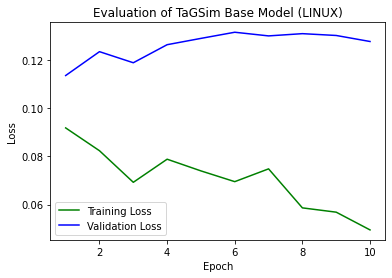


-------Model testing---------.


Model test error: 0.12775831543850863


In [ ]:

model = TaGSim(Node_Types, Edge_Types, tensor_neurons, bottle_neck_neurons)

def fit(model,title):
  optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
  iteration = 0

  visual_loss_train = []
  visual_loss_test = []
  train_pair = []
  test_pair = []
  epo = []
  #model training
  for epoch in range(epochs):
    
      random.shuffle(train_pairs)
      batches = []
      for graph in range(0, len(train_pairs), batch_size):
          batches.append(train_pairs[graph:graph + batch_size])

      for batch in batches:
          model.train()
          optimizer.zero_grad()
          losses = 0
          for graph_pair in batch:
              data = model.transform_label_multiset(graph_pair)
              prediction = model(data)
              losses += torch.nn.functional.mse_loss(data["target"], prediction)

          losses.backward(retain_graph=True)
          optimizer.step()
          loss = losses.item()
          #print('Iteration', iteration, 'loss: ', loss / len(batch))
          iteration += 1

      visual_loss_train.append(loss / len(batch))


      # testing
      model.eval()
      test_scores=[]
      for n in test_pairs:
          graph1 = n['graph_pair'][0]  #updated_test
          graph2 = n['graph_pair'][1]  #updated_test
          ged = int(n['gt_ged'])
          tem_data = {"graph_pair": [graph1, graph2], "ged": ged}
          data = model.transform_label_multiset(tem_data, type_specified=False)
          prediction = model(data)
          prediction = torch.exp(torch.sum(torch.log(prediction))).view(1, -1)
          current_error = torch.nn.functional.mse_loss(prediction, data["gt_ged"])
          test_scores.append(current_error.data.item())
      visual_loss_test.append(sum(test_scores) / len(test_scores))
      epo.append(epoch + 1)


  #visualization of traning and testing loss
  plt.plot(epo, visual_loss_train, 'g', label='Training Loss')
  plt.plot(epo, visual_loss_test, 'b', label='Validation Loss')
  plt.title(title)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

  print("\n-------Model testing---------.\n")

  model.eval()
  test_scores = []
  for n in test_pairs:
      graph1 = n['graph_pair'][0]  #updated_test
      graph2 = n['graph_pair'][1]  #updated_test
      ged = int(n['gt_ged'])
      tem_data = {"graph_pair": [graph1, graph2], "ged": ged}
      data = model.transform_label_multiset(tem_data, type_specified=False)
      prediction = model(data)
      prediction = torch.exp(torch.sum(torch.log(prediction))).view(1, -1)
      prediction = torch.sum(prediction).view(1, -1)
      current_error = torch.nn.functional.mse_loss(prediction, data["gt_ged"])
      test_scores.append(current_error.data.item())

  model_error = sum(test_scores) / len(test_scores)
  print("\nModel test error: " + str(model_error))
  model.testResult=visual_loss_test
model = TaGSim(Node_Types, Edge_Types, tensor_neurons, bottle_neck_neurons)
title='Evaluation of TaGSim Base Model (' + DATASET + ')'
fit(model,title)

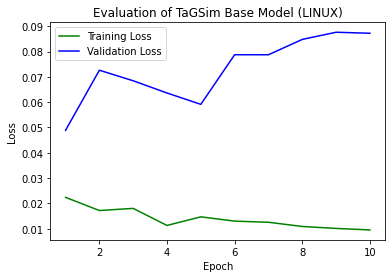


-------Model testing---------.


Model test error: 0.08722529719234444


In [ ]:

model = TaGSim(Node_Types, Edge_Types, tensor_neurons, bottle_neck_neurons)
title='Evaluation of TaGSim Base Model (' + DATASET + ')'
fit(model,title)

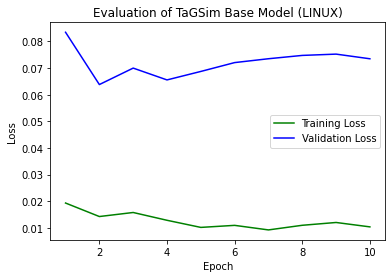


-------Model testing---------.


Model test error: 0.07348150679614004


In [ ]:

model = TaGSim(Node_Types, Edge_Types, tensor_neurons, bottle_neck_neurons)
title='Evaluation of TaGSim Base Model (' + DATASET + ')'
fit(model,title)

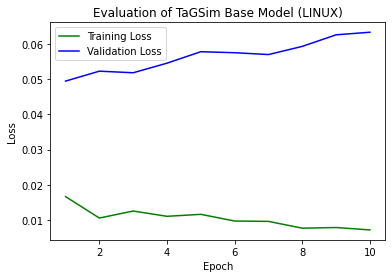


-------Model testing---------.


Model test error: 0.06327186489475675


In [ ]:

model = TaGSim(Node_Types, Edge_Types, tensor_neurons, bottle_neck_neurons)
title='Evaluation of TaGSim Base Model (' + DATASET + ')'
fit(model,title)

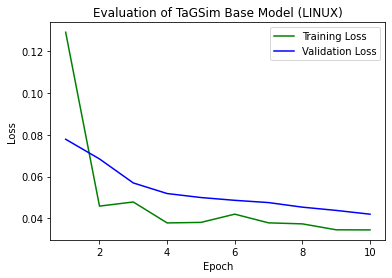


-------Model testing---------.


Model test error: 0.04196368892905217


In [ ]:

model = TaGSim(Node_Types, Edge_Types, tensor_neurons, bottle_neck_neurons)
title='Evaluation of TaGSim Base Model (' + DATASET + ')'
fit(model,title)

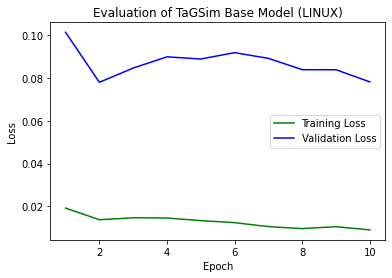


-------Model testing---------.


Model test error: 0.0782245245874427


In [ ]:

model = TaGSim(Node_Types, Edge_Types, tensor_neurons, bottle_neck_neurons)
title='Evaluation of TaGSim Base Model (' + DATASET + ')'
fit(model,title)

NO ID

In [ ]:


class TaGSim_noID(torch.nn.Module):
    def __init__(self, number_of_node_labels, number_of_edge_labels, tensor_neurons, bottle_neck_neurons):
        super(TaGSim_noID, self).__init__()
        # self.number_of_node_labels = len(number_of_node_labels)
        # self.number_of_edge_labels = len(number_of_edge_labels)
        self.tensor_neurons = tensor_neurons
        self.bottle_neck_neurons = bottle_neck_neurons
        self.setup_layers()



    def setup_layers(self):
        self.feature_count = self.tensor_neurons

        # self.tensor_network_nc = TensorNetworkModule(self.tensor_neurons, 2 * self.number_of_node_labels)
        self.tensor_network_in = TensorNetworkModule(self.tensor_neurons, 7)
        # self.tensor_network_ie = TensorNetworkModule(self.tensor_neurons, 2 * self.number_of_node_labels)
        self.tensor_network_ec = TensorNetworkModule(self.tensor_neurons, 23)

        # self.fully_connected_first_nc = torch.nn.Linear(self.feature_count, self.bottle_neck_neurons)
        # self.fully_connected_second_nc = torch.nn.Linear(self.bottle_neck_neurons, 8)
        # self.fully_connected_third_nc = torch.nn.Linear(8, 4)
        # self.scoring_layer_nc = torch.nn.Linear(4, 1)

        self.fully_connected_first_in = torch.nn.Linear(self.feature_count, self.bottle_neck_neurons)
        self.fully_connected_second_in = torch.nn.Linear(self.bottle_neck_neurons, 8)
        self.fully_connected_third_in = torch.nn.Linear(8, 4)
        self.scoring_layer_in = torch.nn.Linear(4, 1)

        # self.fully_connected_first_ie = torch.nn.Linear(self.feature_count, self.bottle_neck_neurons)
        # self.fully_connected_second_ie = torch.nn.Linear(self.bottle_neck_neurons, 8)
        # self.fully_connected_third_ie = torch.nn.Linear(8, 4)
        # self.scoring_layer_ie = torch.nn.Linear(4, 1)

        self.fully_connected_first_ec = torch.nn.Linear(self.feature_count, self.bottle_neck_neurons)
        self.fully_connected_second_ec = torch.nn.Linear(self.bottle_neck_neurons, 8)
        self.fully_connected_third_ec = torch.nn.Linear(8, 4)
        self.scoring_layer_ec = torch.nn.Linear(4, 1)

    def gal_pass(self, edge_index, features):
        hidden1 = graph_aggregation_layer(features, edge_index)
        hidden2 = graph_aggregation_layer(hidden1, edge_index)
        return hidden1, hidden2

    def transform_label_multiset(self, graph_pair, type_specified=True):
        graph1 = graph_pair['graph_pair'][0]
        graph2 = graph_pair['graph_pair'][1]
        ged = graph_pair['ged']
        
        label_multiset = dict()
        node_features_1, node_features_2= [], []

        for i in graph1.nodes():
            node_features_1.append([1.0])
        for i in graph2.nodes():
            node_features_2.append([1.0])

        node_features_1, node_features_2 = torch.FloatTensor(np.array(node_features_1)), torch.FloatTensor(
            np.array(node_features_2))

        #label_multiset["edge_index_1"], label_multiset["edge_index_2"] = nx.adjacency_matrix(graph1), nx.adjacency_matrix(graph2)
        label_multiset["features_1"], label_multiset["features_2"] = node_features_1, node_features_2

        # label_multiset["node_index_1"], label_multiset["node_index_2"] = nx.adjacency_matrix(
        #     graph1), nx.adjacency_matrix(graph2)
        # label_multiset["node_features_1"], label_multiset["node_features_2"] = node_features_1, node_features_2
        # label_multiset["edge_features_1"], label_multiset["edge_features_2"] = edge_features_1, edge_features_2
        # label_multiset["edge_adj_1"], label_multiset["edge_adj_2"] = edge_adj_1, edge_adj_2

        edges1 = list(graph1.edges())
        edges2 = list(graph2.edges())

        node_features_1, node_features_2, edge_features_1, edge_features_2, edge_adj_1, edge_adj_2 = [], [], [], [], [], []

        for i in graph1.nodes():
            node_features_1.append([1.0  ])
        for i in graph2.nodes():
            node_features_2.append([1.0  ])
            

        for i in edges1:
            edge_features_1.append([1.0 ])
            adj_row = []
            for d in edges1:
                if (i == d):
                    adj_row.append(0.0)
                    continue
                if ((i[0] in d) | (i[1] in d)):
                    adj_row.append(1.0)
                else:
                    adj_row.append(0.0)
            edge_adj_1.append(adj_row)
        for i in edges2:
            edge_features_2.append([1.0  ])
            adj_row = []
            for d in edges2:
                if (i == d):
                    adj_row.append(0.0)
                    continue
                if ((i[0] in d) | (i[1] in d)):
                    adj_row.append(1.0)
                else:
                    adj_row.append(0.0)
            edge_adj_2.append(adj_row)
        edge_features_1, edge_features_2 = torch.FloatTensor(np.array(edge_features_1)), torch.FloatTensor(
            np.array(edge_features_2))
        edge_adj_1, edge_adj_2 = torch.FloatTensor(np.array(edge_adj_1)), torch.FloatTensor(np.array(edge_adj_2))


        label_multiset["edge_features_1"], label_multiset["edge_features_2"] = edge_features_1, edge_features_2
        label_multiset["edge_adj_1"], label_multiset["edge_adj_2"] = edge_adj_1, edge_adj_2

        node_features_1,node_features_2=        nx.adjacency_matrix(graph1).todense(), nx.adjacency_matrix(graph2).todense()
        #label_multiset["edge_index_1"], label_multiset["edge_index_2"] = nx.adjacency_matrix(graph1), nx.adjacency_matrix(graph2)
        label_multiset["node_adj_1"], label_multiset["node_adj_2"] =torch.FloatTensor(np.array(node_features_1)), torch.FloatTensor(
            np.array(node_features_2))
        
        if (type_specified):  # for training
            avg_node_number = 0.5 * (graph1.number_of_nodes() + graph2.number_of_nodes())
            norm_ged = [n / avg_node_number for n in ged]
            norm_ged = np.array(norm_ged)
            label_multiset["target"] = torch.from_numpy(np.exp(-norm_ged)).view(1, -1).float()

            norm_gt_ged = (sum(ged)) / (0.5 * (graph1.number_of_nodes() + graph2.number_of_nodes()))
            label_multiset["gt_ged"] = torch.from_numpy(np.exp(-norm_gt_ged).reshape(1, 1)).view(1, -1).float()
        else:  # for testing
            norm_gt_ged = (ged) / (0.5 * (graph1.number_of_nodes() + graph2.number_of_nodes()))
            label_multiset["gt_ged"] = torch.from_numpy(np.exp(-norm_gt_ged).reshape(1, 1)).view(1, -1).float()

        return label_multiset
    def forward(self, label_multiset):
      adj_1 =  label_multiset["edge_adj_1"]
      adj_2 =  label_multiset["edge_adj_2"] 
      adj_1 =  label_multiset["node_adj_1"]
      adj_2 =  label_multiset["node_adj_2"] 
      features_1, features_2 = label_multiset["features_1"],label_multiset["features_2"]
      edge_adj_1, edge_adj_2 = label_multiset["edge_adj_1"], label_multiset["edge_adj_2"]
      
      edge_features_1, edge_features_2 = label_multiset["edge_features_1"], label_multiset["edge_features_2"]

              
      graph1_hidden1, graph1_hidden2 = self.gal_pass(adj_1, features_1)#
      graph2_hidden1, graph2_hidden2 = self.gal_pass(adj_2, features_2)#
    
      Graph1_hidden1, Graph1_hidden2, Graph2_hidden1, Graph2_hidden2 = [], [], [], []
      for i in range(graph1_hidden1.size()[0]):
        if(graph1_hidden1[i][0] >= 6):# 10 for imdb; 6 for linux # the valus here can be set by the users
            Graph1_hidden1.append([0.0]*5 + [1.0])
        else:
            Graph1_hidden1.append([1.0 if graph1_hidden1[i][0] == j else 0.0 for j in range(6)])

        if(graph1_hidden2[i][0] >= 15):# 50 for imdb; 15 for linux # the valus here can be set by the users
            Graph1_hidden2.append([0.0]*14 + [1.0])
        else:
            Graph1_hidden2.append([1.0 if graph1_hidden2[i][0] == j else 0.0 for j in range(15)])

      for i in range(graph2_hidden1.size()[0]):
          if(graph2_hidden1[i][0] >= 6):# 10 for imdb; 6 for linux # the valus here can be set by the users
              Graph2_hidden1.append([0.0]*5 + [1.0])
          else:
              Graph2_hidden1.append([1.0 if graph2_hidden1[i][0] == j else 0.0 for j in range(6)])

          if(graph2_hidden2[i][0] >= 15):# 50 for imdb; 15 for linux # the valus here can be set by the users
              Graph2_hidden2.append([0.0]*14 + [1.0])
          else:
              Graph2_hidden2.append([1.0 if graph2_hidden2[i][0] == j else 0.0 for j in range(15)])
      Graph1_hidden1, Graph1_hidden2 = torch.FloatTensor(np.array(Graph1_hidden1)), torch.FloatTensor(np.array(Graph1_hidden2))
      Graph2_hidden1, Graph2_hidden2 = torch.FloatTensor(np.array(Graph2_hidden1)), torch.FloatTensor(np.array(Graph2_hidden2))


      edge1_hidden1, edge1_hidden2 = self.gal_pass(edge_adj_1, edge_features_1)  #original edge node
      edge2_hidden1, edge2_hidden2 = self.gal_pass(edge_adj_2, edge_features_2)  #generated graph edge


      graph1_01concat = torch.cat([features_1, Graph1_hidden1], dim=1)
      graph2_01concat = torch.cat([features_2, Graph2_hidden1], dim=1)
      graph1_12concat = torch.cat([Graph1_hidden1, Graph1_hidden2], dim=1)
      graph2_12concat = torch.cat([Graph2_hidden1, Graph2_hidden2], dim=1)

      graph1_01pooled = torch.sum(graph1_01concat, dim=0).unsqueeze(1)# default: sum
      graph2_01pooled = torch.sum(graph2_01concat, dim=0).unsqueeze(1)
      graph1_12pooled = torch.sum(graph1_12concat, dim=0)
      graph2_12pooled = torch.sum(graph2_12concat, dim=0)




      #scores_in = self.tensor_network_in(graph1_01pooled, graph2_01pooled)
      #scores_in = torch.t(scores_in)
#
      #scores_in = torch.nn.functional.relu(self.fully_connected_first_in(scores_in))
      #scores_in = torch.nn.functional.relu(self.fully_connected_second_in(scores_in))
      #scores_in = torch.nn.functional.relu(self.fully_connected_third_in(scores_in))
      #score_in = torch.sigmoid(self.scoring_layer_in(scores_in))


        #edge level embedding Concatenation
      edge1_01concat = torch.cat([ edge_features_1, edge1_hidden1], dim=1)
      edge2_01concat = torch.cat([ edge_features_2, edge2_hidden1], dim=1)
      #graph pooling: edge Sum
      edge1_01pooled = torch.sum(edge1_01concat, dim=0)
      edge2_01pooled = torch.sum(edge2_01concat, dim=0)

      graph1_ec_input=torch.cat([ graph1_12pooled, edge1_01pooled]).unsqueeze(1)
      graph2_ec_input=torch.cat([ graph2_12pooled, edge2_01pooled]).unsqueeze(1)
      scores_ec = self.tensor_network_ec(graph1_ec_input, graph2_ec_input)
      scores_ec = torch.t(scores_ec)

      scores_ec = torch.nn.functional.relu(self.fully_connected_first_ec(scores_ec))
      scores_ec = torch.nn.functional.relu(self.fully_connected_second_ec(scores_ec))
      scores_ec = torch.nn.functional.relu(self.fully_connected_third_ec(scores_ec))
      score_ec = torch.sigmoid(self.scoring_layer_ec(scores_ec))
                     #edge insert
      return torch.cat([ score_ec], dim=1)
# test_csv = pd.DataFrame(test_data, columns=['G1', 'G2', 'gt_ged']).to_csv(DATASET_FOLDER + "/testing_pairs.csv",
#                                                                           index=False)
def load_pairs_NID():
    train_pairs = []
    train_csv = pd.read_csv(DATASET_FOLDER+"/training_pairs.csv")
    for index, row in train_csv.iterrows():
        file1 = row['G1']
        file2 = row['G2']
        ged =ast.literal_eval(row['GED'])
        new_ged = [ged[3]]
        graph1 = nx.read_gexf(path=ORI_DIR + '/' + file1)
        graph2 = nx.read_gexf(path=GEN_DIR + '/' + file2)
        gt_ged = row['gt_ged']-abs(graph1.number_of_nodes() -graph2.number_of_nodes())
        train_pairs.append({"graph_pair": [graph1, graph2], "ged": new_ged, "gt_ged":gt_ged})


    test_pairs = []
    test_csv = pd.read_csv(DATASET_FOLDER+"/testing_pairs.csv")
    for index, row in test_csv.iterrows():
        file1 = row['G2']
        file2 = row['G1']
        graph1 = nx.read_gexf(path=TEST_GEN_DIR + '/' + file1)
        graph2 = nx.read_gexf(path=TEST_DIR + '/' + file2)
        gt_ged = row['gt_ged']-abs(graph1.number_of_nodes()- graph2.number_of_nodes())
        test_pairs.append({"graph_pair": [graph1, graph2], "gt_ged": gt_ged})
    return train_pairs, test_pairs
train_pairs_NID, test_pairs_NID = load_pairs_NID()
print(len(train_pairs_NID))
print(train_pairs_NID[0])
print(len(test_pairs_NID))
print(test_pairs_NID[0])

2001
{'graph_pair': [<networkx.classes.graph.Graph object at 0x7f604d2c8ed0>, <networkx.classes.graph.Graph object at 0x7f604d2c86d0>], 'ged': [1], 'gt_ged': 1}
70
{'graph_pair': [<networkx.classes.graph.Graph object at 0x7f60448dca10>, <networkx.classes.graph.Graph object at 0x7f60448dc510>], 'gt_ged': 6.0}



-------Model training---------.

Iteration 0 loss:  0.5186823010444641
Iteration 1 loss:  0.47580552101135254
Iteration 2 loss:  0.47999534010887146
Iteration 3 loss:  0.42841005325317383
Iteration 4 loss:  0.432224303483963
Iteration 5 loss:  0.4815744459629059
Iteration 6 loss:  0.4539036750793457
Iteration 7 loss:  0.38909587264060974
Iteration 8 loss:  0.44097447395324707
Iteration 9 loss:  0.42715561389923096
Iteration 10 loss:  0.431616872549057
Iteration 11 loss:  0.3641466200351715
Iteration 12 loss:  0.35809609293937683
Iteration 13 loss:  0.38850241899490356
Iteration 14 loss:  0.3489924371242523
Iteration 15 loss:  0.32450492293746386
Iteration 16 loss:  0.3972257673740387
Iteration 17 loss:  0.2969789505004883
Iteration 18 loss:  0.3481835722923279
Iteration 19 loss:  0.32632362842559814
Iteration 20 loss:  0.35563358664512634
Iteration 21 loss:  0.35711222887039185
Iteration 22 loss:  0.3410373330116272
Iteration 23 loss:  0.30816343426704407
Iteration 24 loss:  0.3023917

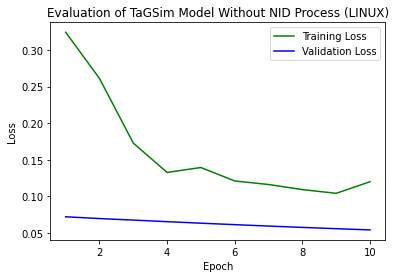


-------Model testing---------.


Model test error: 0.0538314835923042


In [ ]:

import matplotlib.pyplot as plt

epochs = 10
tensor_neurons = 16
bottle_neck_neurons = 16
batch_size = 128
dropout = 0.0
lr = 0.001
weight_decay = 0.0

Node_Types = ['1']
Edge_Types = ['1']
#collection global node label and edge label info

print("\n-------Model training---------.\n")

model = TaGSim_noID(Node_Types, Edge_Types, tensor_neurons, bottle_neck_neurons)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
iteration = 0

visual_loss_train = []
visual_loss_test = []
train_pair = []
test_pair = []
epo = []
#model training
for epoch in range(epochs):
  
    random.shuffle(train_pairs_NID)
    batches = []
    for graph in range(0, len(train_pairs_NID), batch_size):
        batches.append(train_pairs_NID[graph:graph + batch_size])
    for batch in batches:
        model.train()
        optimizer.zero_grad()
        losses = 0
        for graph_pair in batch:
            data = model.transform_label_multiset(graph_pair)
            prediction = model(data)
            losses += torch.nn.functional.mse_loss(data["target"], prediction)

        losses.backward(retain_graph=True)
        optimizer.step()
        loss = losses.item()
        print('Iteration', iteration, 'loss: ', loss / len(batch))
        iteration += 1

    visual_loss_train.append(loss / len(batch))


    # testing
    model.eval()
    test_scores=[]
    for n in test_pairs_NID:
        graph1 = n['graph_pair'][0]  #updated_test
        graph2 = n['graph_pair'][1]  #updated_test
        ged = int(n['gt_ged'])
        tem_data = {"graph_pair": [graph1, graph2], "ged": ged}
        data = model.transform_label_multiset(tem_data, type_specified=False)
        prediction = model(data)
        prediction = torch.exp(torch.sum(torch.log(prediction))).view(1, -1)
        current_error = torch.nn.functional.mse_loss(prediction, data["gt_ged"])
        test_scores.append(current_error.data.item())
    visual_loss_test.append(sum(test_scores) / len(test_scores))
    epo.append(epoch + 1)


#visualization of traning and testing loss
plt.plot(epo, visual_loss_train, 'g', label='Training Loss')
plt.plot(epo, visual_loss_test, 'b', label='Validation Error Rate')
plt.title('Evaluation of TaGSim Model Without NID Process (' + DATASET + ')')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

print("\n-------Model testing---------.\n")

model.eval()
test_scores = []
for n in test_pairs_NID:
    graph1 = n['graph_pair'][0]  #updated_test
    graph2 = n['graph_pair'][1]  #updated_test
    ged = int(n['gt_ged'])
    tem_data = {"graph_pair": [graph1, graph2], "ged": ged}
    data = model.transform_label_multiset(tem_data, type_specified=False)
    prediction = model(data)
    prediction = torch.exp(torch.sum(torch.log(prediction))).view(1, -1)
    prediction = torch.sum(prediction).view(1, -1)
    current_error = torch.nn.functional.mse_loss(prediction, data["gt_ged"])
    test_scores.append(current_error.data.item())

model_error = sum(test_scores) / len(test_scores)
print("\nModel test error: " + str(model_error))


-------Model training---------.



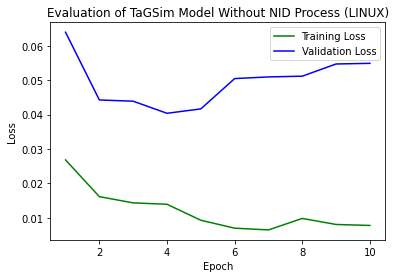


-------Model testing---------.


Model test error: 0.05487468534078549


In [ ]:

import matplotlib.pyplot as plt

epochs = 10
tensor_neurons = 16
bottle_neck_neurons = 16
batch_size = 128
dropout = 0.0
lr = 0.001
weight_decay = 0.0

Node_Types = ['1']
Edge_Types = ['1']
#collection global node label and edge label info

print("\n-------Model training---------.\n")

model = TaGSim_noID(Node_Types, Edge_Types, tensor_neurons, bottle_neck_neurons)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
iteration = 0

visual_loss_train = []
visual_loss_test = []
train_pair = []
test_pair = []
epo = []
#model training
for epoch in range(epochs):
  
    random.shuffle(train_pairs_NID)
    batches = []
    for graph in range(0, len(train_pairs_NID), batch_size):
        batches.append(train_pairs_NID[graph:graph + batch_size])
    for batch in batches:
        model.train()
        optimizer.zero_grad()
        losses = 0
        for graph_pair in batch:
            data = model.transform_label_multiset(graph_pair)
            prediction = model(data)
            losses += torch.nn.functional.mse_loss(data["target"], prediction)

        losses.backward(retain_graph=True)
        optimizer.step()
        loss = losses.item()
        iteration += 1

    visual_loss_train.append(loss / len(batch))


    # testing
    model.eval()
    test_scores=[]
    for n in test_pairs_NID:
        graph1 = n['graph_pair'][0]  #updated_test
        graph2 = n['graph_pair'][1]  #updated_test
        ged = int(n['gt_ged'])
        tem_data = {"graph_pair": [graph1, graph2], "ged": ged}
        data = model.transform_label_multiset(tem_data, type_specified=False)
        prediction = model(data)
        prediction = torch.exp(torch.sum(torch.log(prediction))).view(1, -1)
        current_error = torch.nn.functional.mse_loss(prediction, data["gt_ged"])
        test_scores.append(current_error.data.item())
    visual_loss_test.append(sum(test_scores) / len(test_scores))
    epo.append(epoch + 1)


#visualization of traning and testing loss
plt.plot(epo, visual_loss_train, 'g', label='Training Loss')
plt.plot(epo, visual_loss_test, 'b', label='Validation Error Rate')
plt.title('Evaluation of TaGSim Model Without NID Process (' + DATASET + ')')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

print("\n-------Model testing---------.\n")

model.eval()
test_scores = []
for n in test_pairs_NID:
    graph1 = n['graph_pair'][0]  #updated_test
    graph2 = n['graph_pair'][1]  #updated_test
    ged = int(n['gt_ged'])
    tem_data = {"graph_pair": [graph1, graph2], "ged": ged}
    data = model.transform_label_multiset(tem_data, type_specified=False)
    prediction = model(data)
    prediction = torch.exp(torch.sum(torch.log(prediction))).view(1, -1)
    prediction = torch.sum(prediction).view(1, -1)
    current_error = torch.nn.functional.mse_loss(prediction, data["gt_ged"])
    test_scores.append(current_error.data.item())

model_error = sum(test_scores) / len(test_scores)
print("\nModel test error: " + str(model_error))

In [ ]:

import matplotlib.pyplot as plt

epochs = 10
tensor_neurons = 16
bottle_neck_neurons = 16
batch_size = 128
dropout = 0.0
lr = 0.001
weight_decay = 0.0

Node_Types = ['1']
Edge_Types = ['1']
#collection global node label and edge label info

print("\n-------Model training---------.\n")

model = TaGSim_noID(Node_Types, Edge_Types, tensor_neurons, bottle_neck_neurons)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
iteration = 0

visual_loss_train = []
visual_loss_test = []
train_pair = []
test_pair = []
epo = []
#model training
for epoch in range(epochs):
  
    random.shuffle(train_pairs_NID)
    batches = []
    for graph in range(0, len(train_pairs_NID), batch_size):
        batches.append(train_pairs_NID[graph:graph + batch_size])
    for batch in batches:
        model.train()
        optimizer.zero_grad()
        losses = 0
        for graph_pair in batch:
            data = model.transform_label_multiset(graph_pair)
            prediction = model(data)
            losses += torch.nn.functional.mse_loss(data["target"], prediction)

        losses.backward(retain_graph=True)
        optimizer.step()
        loss = losses.item()
        iteration += 1

    visual_loss_train.append(loss / len(batch))


    # testing
    model.eval()
    test_scores=[]
    for n in test_pairs_NID:
        graph1 = n['graph_pair'][0]  #updated_test
        graph2 = n['graph_pair'][1]  #updated_test
        ged = int(n['gt_ged'])
        tem_data = {"graph_pair": [graph1, graph2], "ged": ged}
        data = model.transform_label_multiset(tem_data, type_specified=False)
        prediction = model(data)
        prediction = torch.exp(torch.sum(torch.log(prediction))).view(1, -1)
        current_error = torch.nn.functional.mse_loss(prediction, data["gt_ged"])
        test_scores.append(current_error.data.item())
    visual_loss_test.append(sum(test_scores) / len(test_scores))
    epo.append(epoch + 1)


#visualization of traning and testing loss
plt.plot(epo, visual_loss_train, 'g', label='Training Loss')
plt.plot(epo, visual_loss_test, 'b', label='Validation Error Rate')
plt.title('Evaluation of TaGSim Model Without NID Process (' + DATASET + ')')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

print("\n-------Model testing---------.\n")

model.eval()
test_scores = []
for n in test_pairs_NID:
    graph1 = n['graph_pair'][0]  #updated_test
    graph2 = n['graph_pair'][1]  #updated_test
    ged = int(n['gt_ged'])
    tem_data = {"graph_pair": [graph1, graph2], "ged": ged}
    data = model.transform_label_multiset(tem_data, type_specified=False)
    prediction = model(data)
    prediction = torch.exp(torch.sum(torch.log(prediction))).view(1, -1)
    prediction = torch.sum(prediction).view(1, -1)
    current_error = torch.nn.functional.mse_loss(prediction, data["gt_ged"])
    test_scores.append(current_error.data.item())

model_error = sum(test_scores) / len(test_scores)
print("\nModel test error: " + str(model_error))


-------Model training---------.

